# Preprocessing(2) & Analysis 

## Importing Necessary Libraries

In [1]:
# General imports
import re
import ast
import math
import joblib
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import plot_tree

# Statistical methods
from scipy import stats

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam, SGD

## Loading Data 

In [2]:
df = pd.read_csv('preprocessed_game_info.csv')

In [3]:
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            print(f"Conversion failed for column: {column}")

Conversion failed for column: NAME
Conversion failed for column: DEVELOPERS


In [4]:
technologies = [col for col in df.columns if col.startswith('TECH')]
genres = [col for col in df.columns if col.startswith('GENRE')]
platforms = [col for col in df.columns if col.startswith('OS')]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()

categorical_features = [col for col in categorical_features if col not in technologies + genres + platforms]
numerical_features = [col for col in numerical_features if col not in technologies + genres + platforms]

label_encoders = {}
for column in ['NAME', 'DEVELOPERS']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# print("Technologies:", technologies)
# print("Genres:", genres)
# print("Platforms:", platforms)
# print("Categorical Features:", categorical_features)
# print("Numerical Features:", numerical_features)

## Initial Data Exploration

In [5]:
df.head()

,NAME,N_SUPPORTED_LANGUAGES,DEVELOPERS,POSITIVE_REVIEWS,NEGATIVE_REVIEWS,PRICE,24_HOUR_PEAK,PUBLISH_YEAR,RATING_SCORE,TOTAL_RATE_SUM,...,GENRE: Indie,GENRE: Massively Multiplayer,GENRE: RPG,GENRE: Racing,GENRE: Simulation,GENRE: Sports,GENRE: Strategy,OS: Linux,OS: Windows,OS: macOS
0,470,7,205,39271,5015,NaN,1064.0,2016,0.886759,44286,...,0,0,1,0,0,0,0,0,1,0
1,614,24,999,156683,21075,NaN,16131.0,2021,0.881440,177758,...,0,0,0,1,1,1,0,0,1,0
2,1729,1,1067,872,70,4.99,21.0,2021,0.925690,942,...,1,0,0,0,1,0,0,1,1,0
3,894,12,149,22766,2819,NaN,31.0,2016,0.889818,25585,...,1,0,0,0,0,0,0,1,1,1
4,1587,1,1528,834,66,NaN,318.0,2023,0.926667,900,...,1,0,0,0,0,0,0,0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 165 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(159)
memory usage: 2.5 MB


## Plot the Count of Unique Values for Each Feature 

In [7]:
unique_counts_categorical = df[categorical_features].nunique()
unique_counts_numerical = df[numerical_features].nunique()

tech_count = len(technologies)
genre_count = len(genres)
platform_count = len(platforms)

counts = pd.concat([unique_counts_categorical, unique_counts_numerical])
counts['Technologies'] = tech_count
counts['Genres'] = genre_count
counts['Platforms'] = platform_count

feature_colors = sns.color_palette('hls', n_colors=len(categorical_features) + len(numerical_features) + 3)
features = counts.index.tolist()
feature_color_map = dict(zip(features, feature_colors))
colors = [feature_color_map[feature] for feature in features]


In [8]:
features

['NAME',
 'DEVELOPERS',
 'N_SUPPORTED_LANGUAGES',
 'POSITIVE_REVIEWS',
 'NEGATIVE_REVIEWS',
 'PRICE',
 '24_HOUR_PEAK',
 'PUBLISH_YEAR',
 'RATING_SCORE',
 'TOTAL_RATE_SUM',
 'TWITCH_PEAK_HOUR',
 'TWITCH_PEAK_YEAR',
 'Technologies',
 'Genres',
 'Platforms']

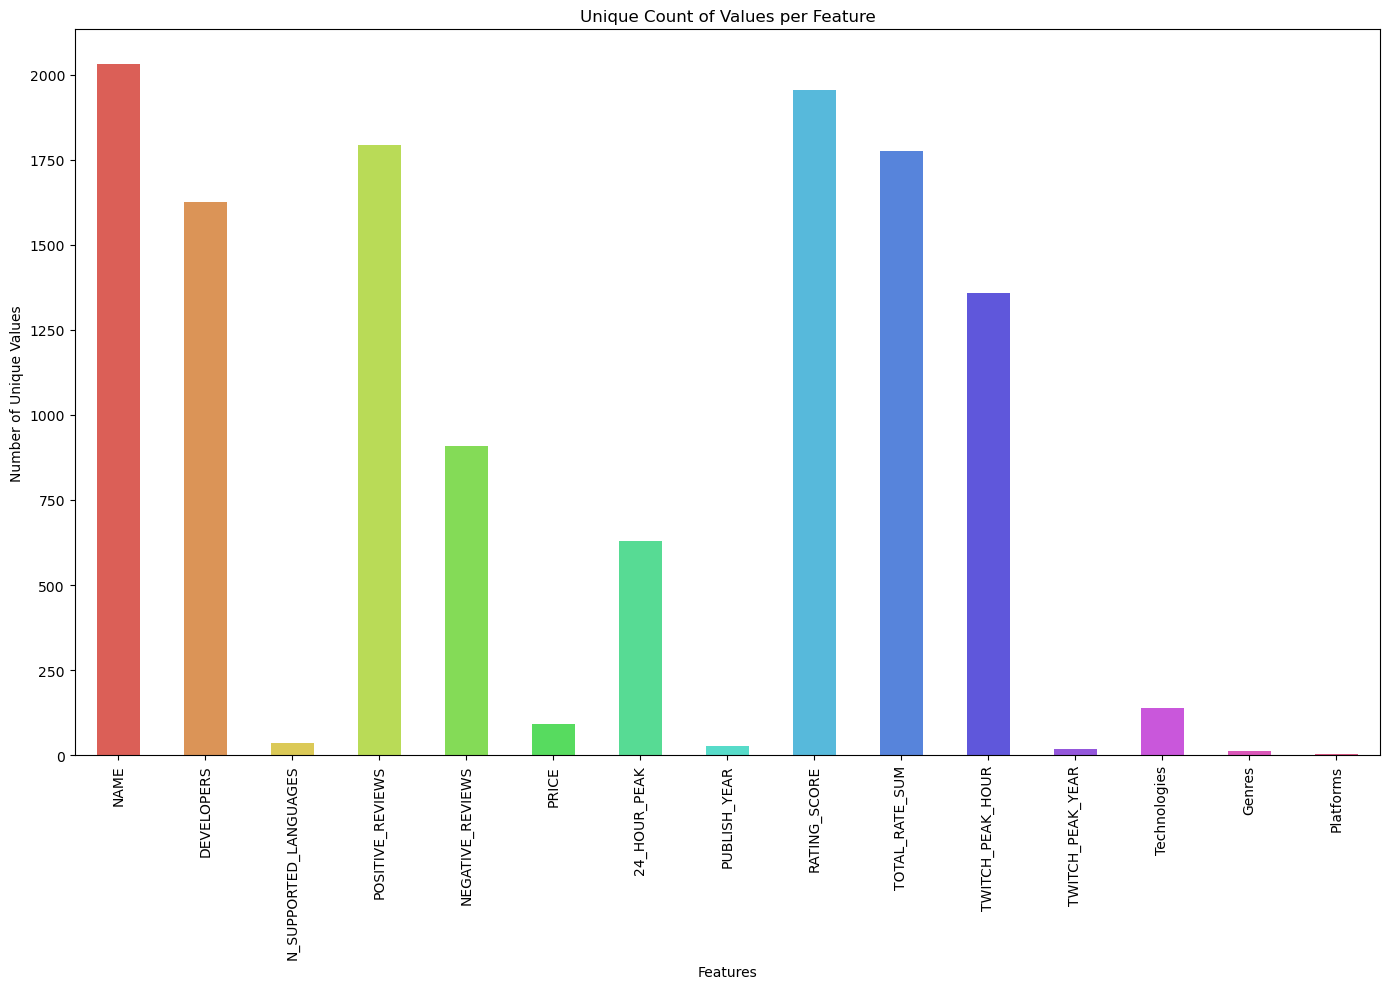

In [9]:
plt.figure(figsize=(14, 10))
counts.plot(kind='bar', color=colors)
plt.title('Unique Count of Values per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Outlier Detection and Handling

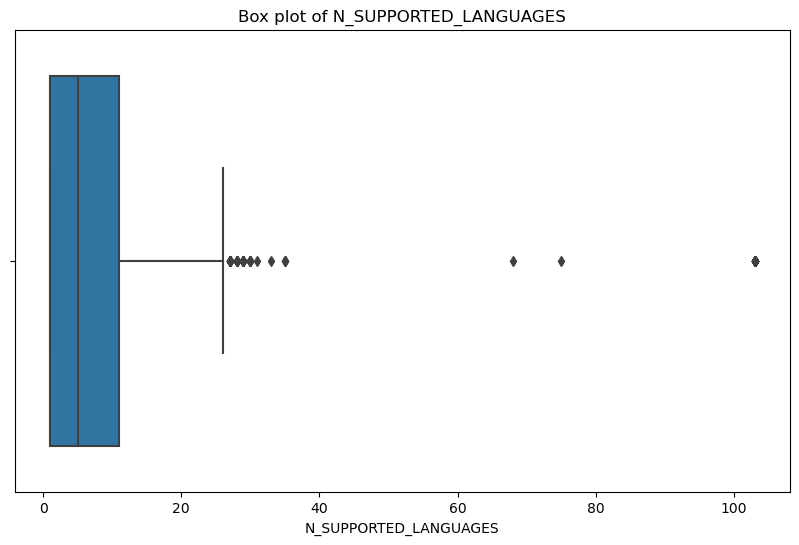

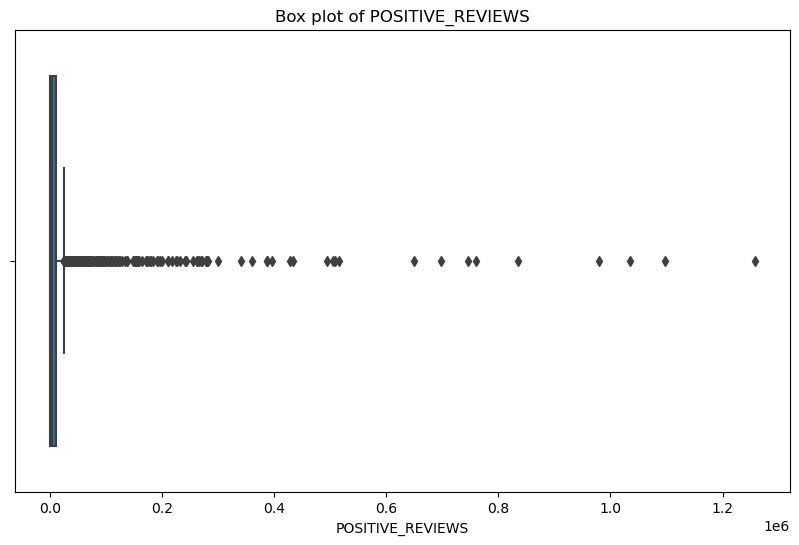

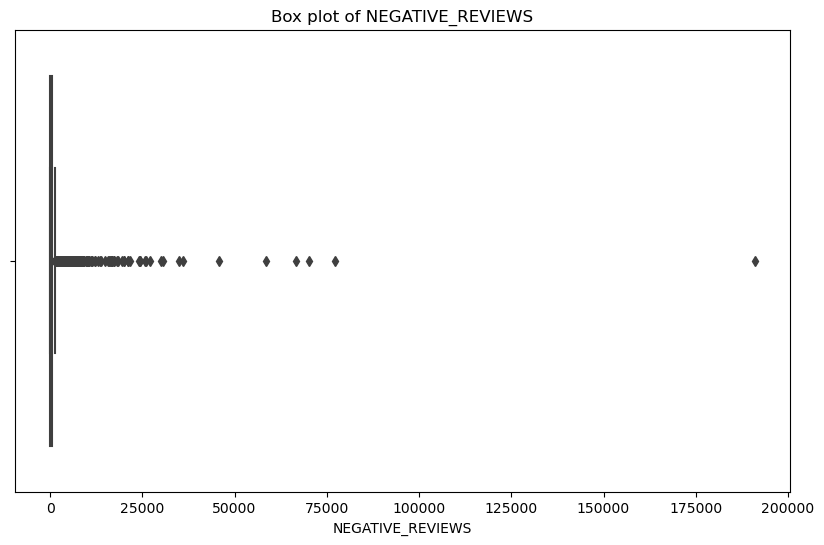

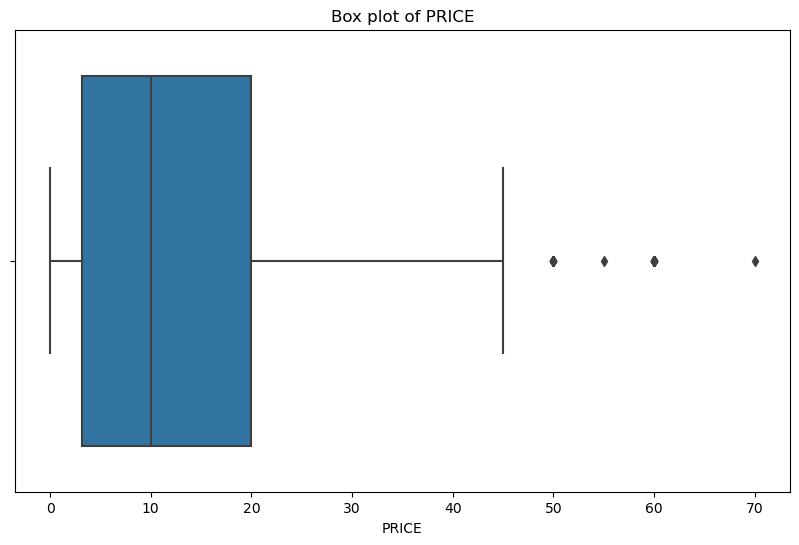

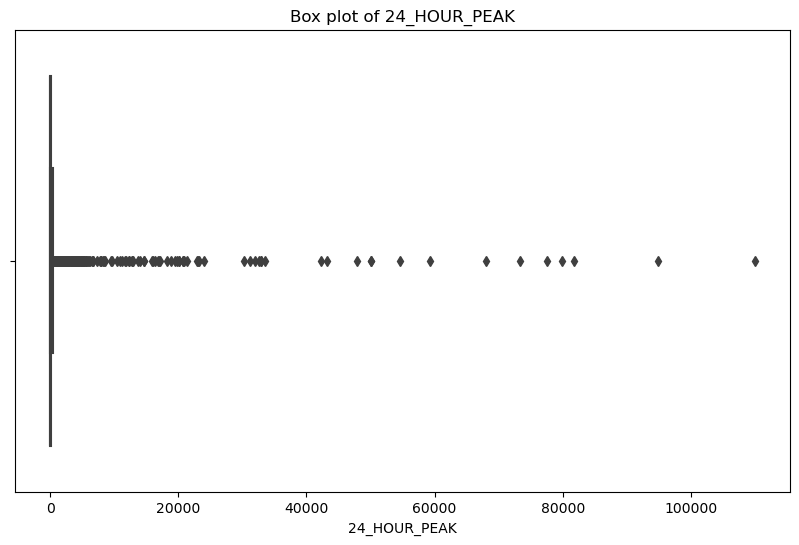

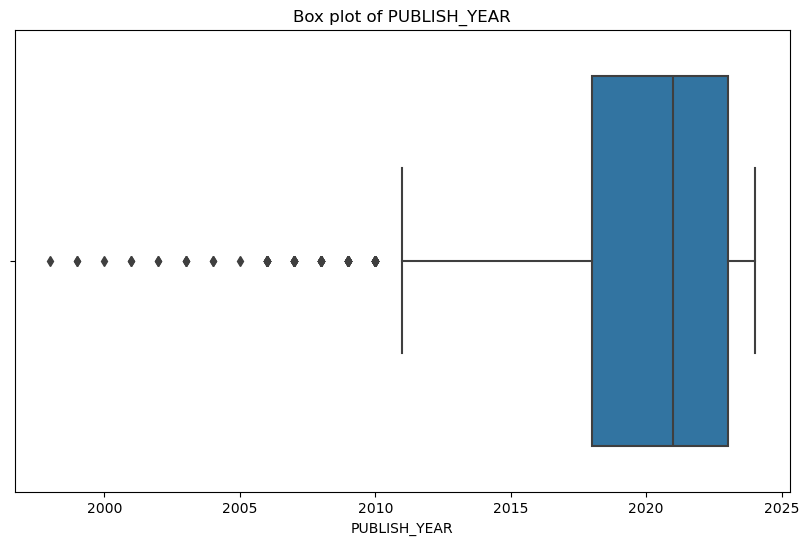

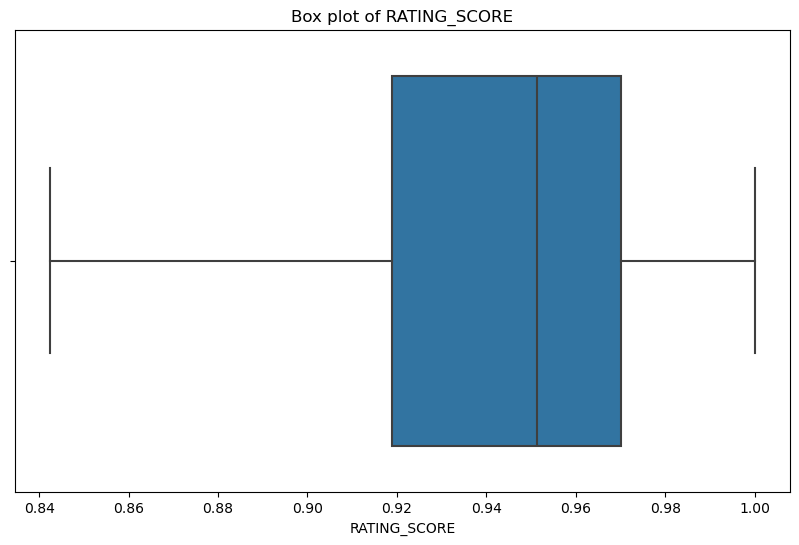

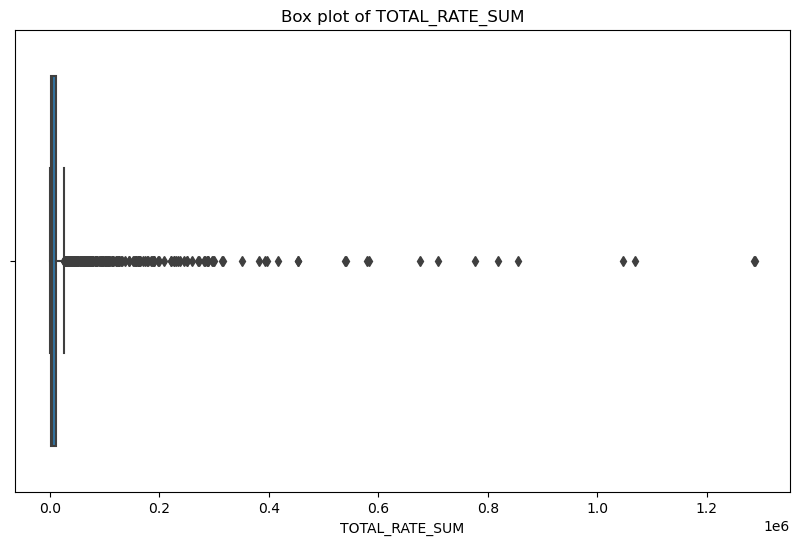

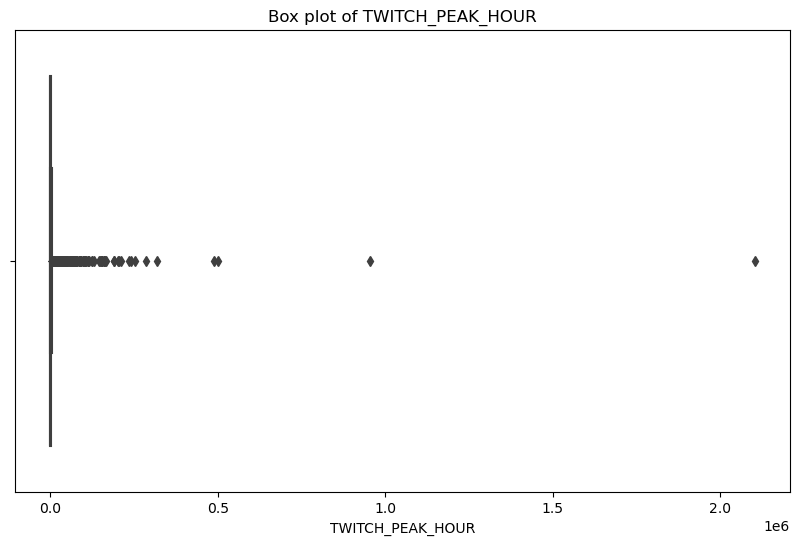

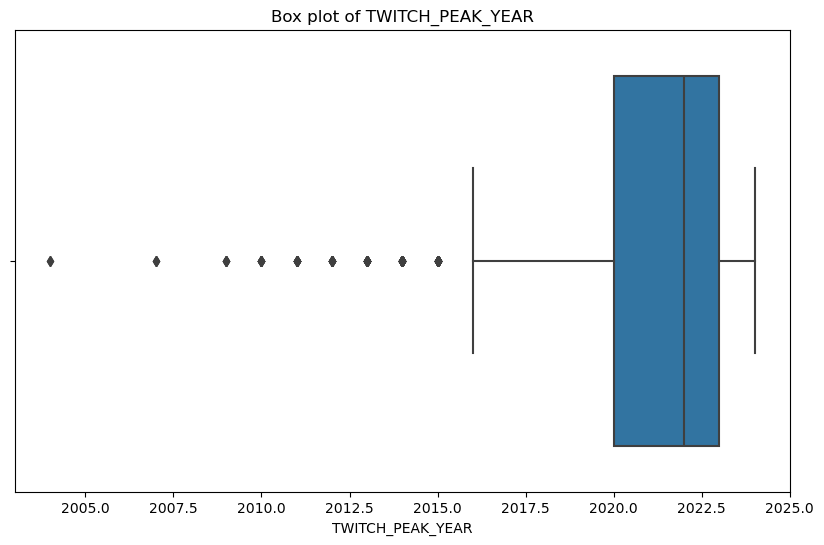

In [10]:
methods = {}

for column in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

    mean = df[column].mean()
    median = df[column].median()
    std = df[column].std()
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    
    if len(outliers) / len(df) < 0.05:
        if abs(mean - median) / std > 0.5:
            methods[column] = 'transform'
        else:
            methods[column] = 'remove'
    else:
        methods[column] = 'cap'

In [11]:
methods

{'N_SUPPORTED_LANGUAGES': 'remove',
 'POSITIVE_REVIEWS': 'cap',
 'NEGATIVE_REVIEWS': 'cap',
 'PRICE': 'remove',
 '24_HOUR_PEAK': 'cap',
 'PUBLISH_YEAR': 'remove',
 'RATING_SCORE': 'remove',
 'TOTAL_RATE_SUM': 'cap',
 'TWITCH_PEAK_HOUR': 'cap',
 'TWITCH_PEAK_YEAR': 'cap'}

**Outlier Handling Suggestions:**
- Transform: Suggested if there is a significant skew in the data (mean and median are far apart relative to the standard deviation).
- Remove: Suggested if the number of outliers is low and the data distribution is not heavily skewed.
- Cap: Suggested if the number of outliers is high, indicating that simply removing them might lead to loss of significant data.

In [12]:
# def handle_outliers(df, methods, exclude_columns=[]):

#     df_cleaned = df.copy()  
    
#     for column, method in methods.items():
#         if column in exclude_columns:
#             continue
        
#         Q1 = df_cleaned[column].quantile(0.25)
#         Q3 = df_cleaned[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         if method == 'remove':
#             df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
#         elif method == 'cap':
#             df_cleaned[column] = df_cleaned[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
#         elif method == 'transform':
#             df_cleaned[column] = np.log1p(df_cleaned[column])  
#         else:
#             raise ValueError("Method must be either 'remove', 'cap', or 'transform'")
    
#     return df_cleaned

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 165 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(159)
memory usage: 2.5 MB


# Feature Engineering and Selection (Analysis) 

In [14]:
target_column = '24_HOUR_PEAK'

## Correlation Heatmap

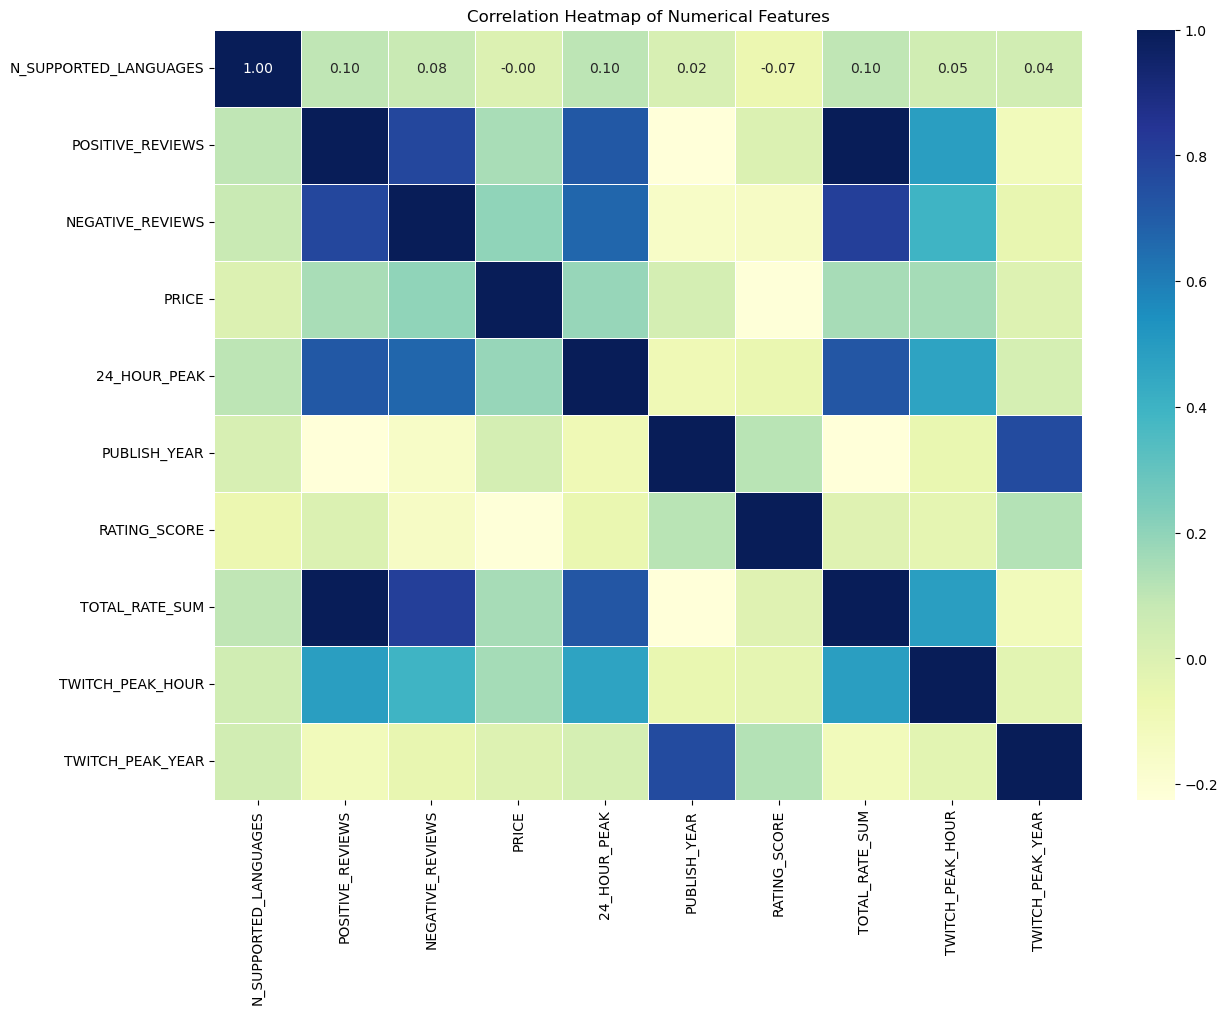

In [15]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [16]:
correlations_with_target = df[numerical_features + [target_column]].corr()[target_column].drop(target_column)

print("Correlation of numerical features with the target variable '24_HOUR_PEAK':")
print(correlations_with_target)


Correlation of numerical features with the target variable '24_HOUR_PEAK':
                       24_HOUR_PEAK  24_HOUR_PEAK
N_SUPPORTED_LANGUAGES      0.102634      0.102634
POSITIVE_REVIEWS           0.713983      0.713983
NEGATIVE_REVIEWS           0.667456      0.667456
PRICE                      0.185387      0.185387
PUBLISH_YEAR              -0.087232     -0.087232
RATING_SCORE              -0.059560     -0.059560
TOTAL_RATE_SUM             0.721471      0.721471
TWITCH_PEAK_HOUR           0.465874      0.465874
TWITCH_PEAK_YEAR           0.027272      0.027272


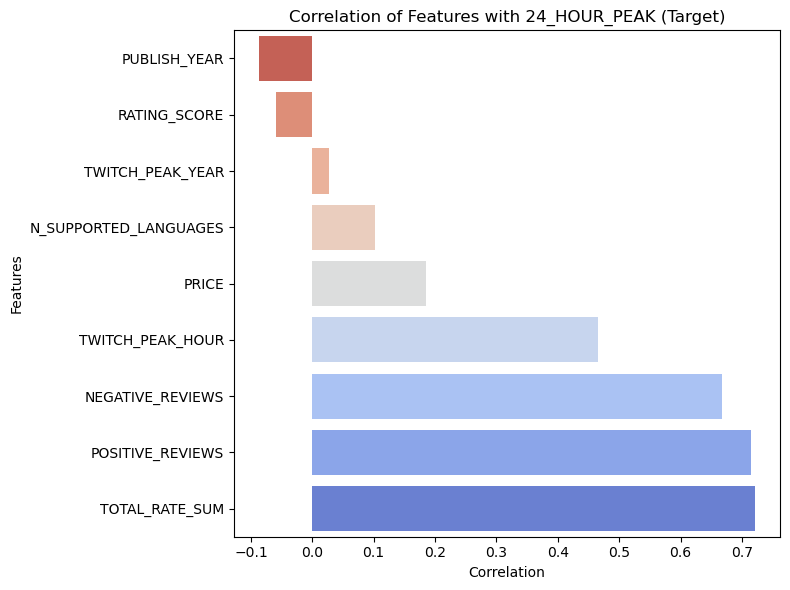

In [17]:
target_correlation = correlation_matrix['24_HOUR_PEAK'].drop('24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## Histograms

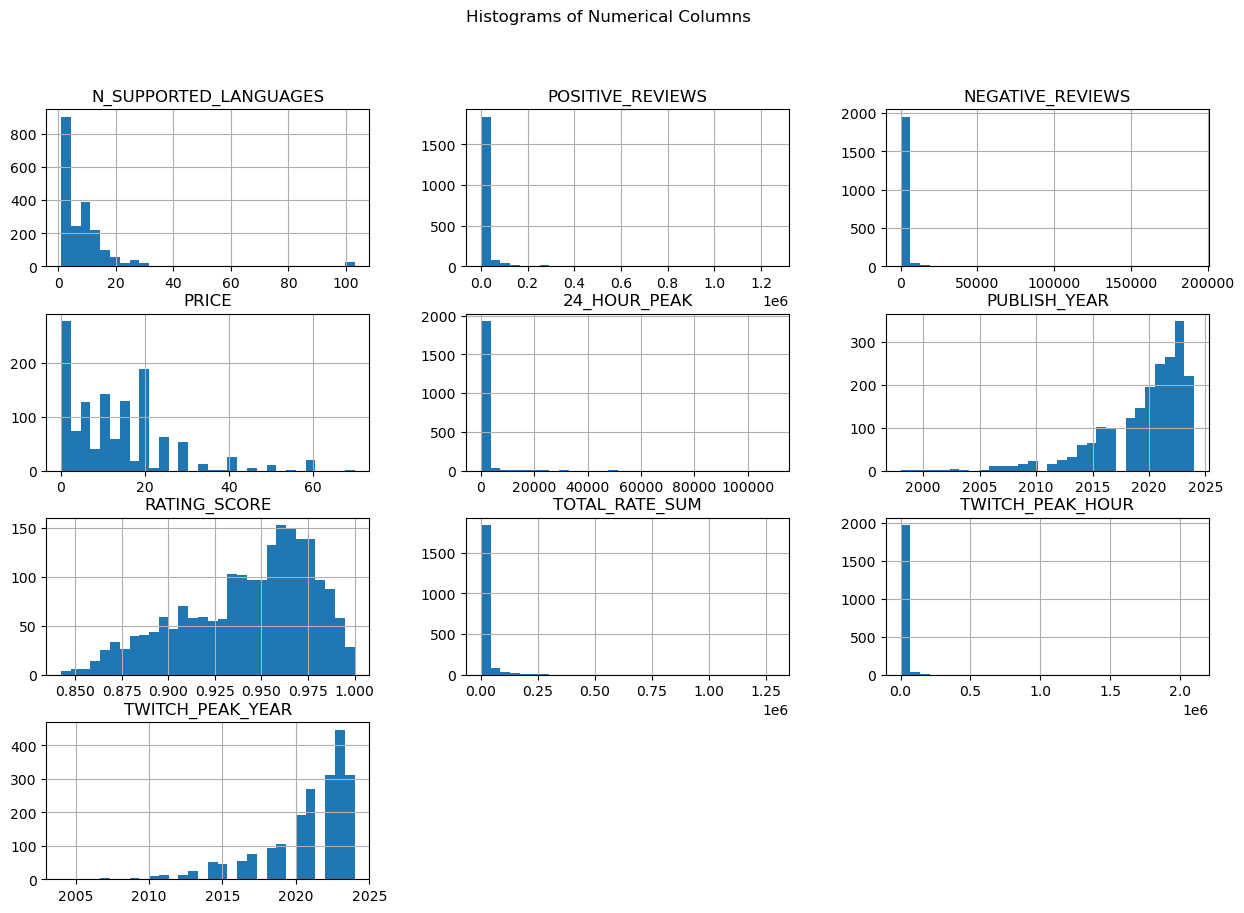

In [18]:
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns")
plt.show()

##  Plot pair plot

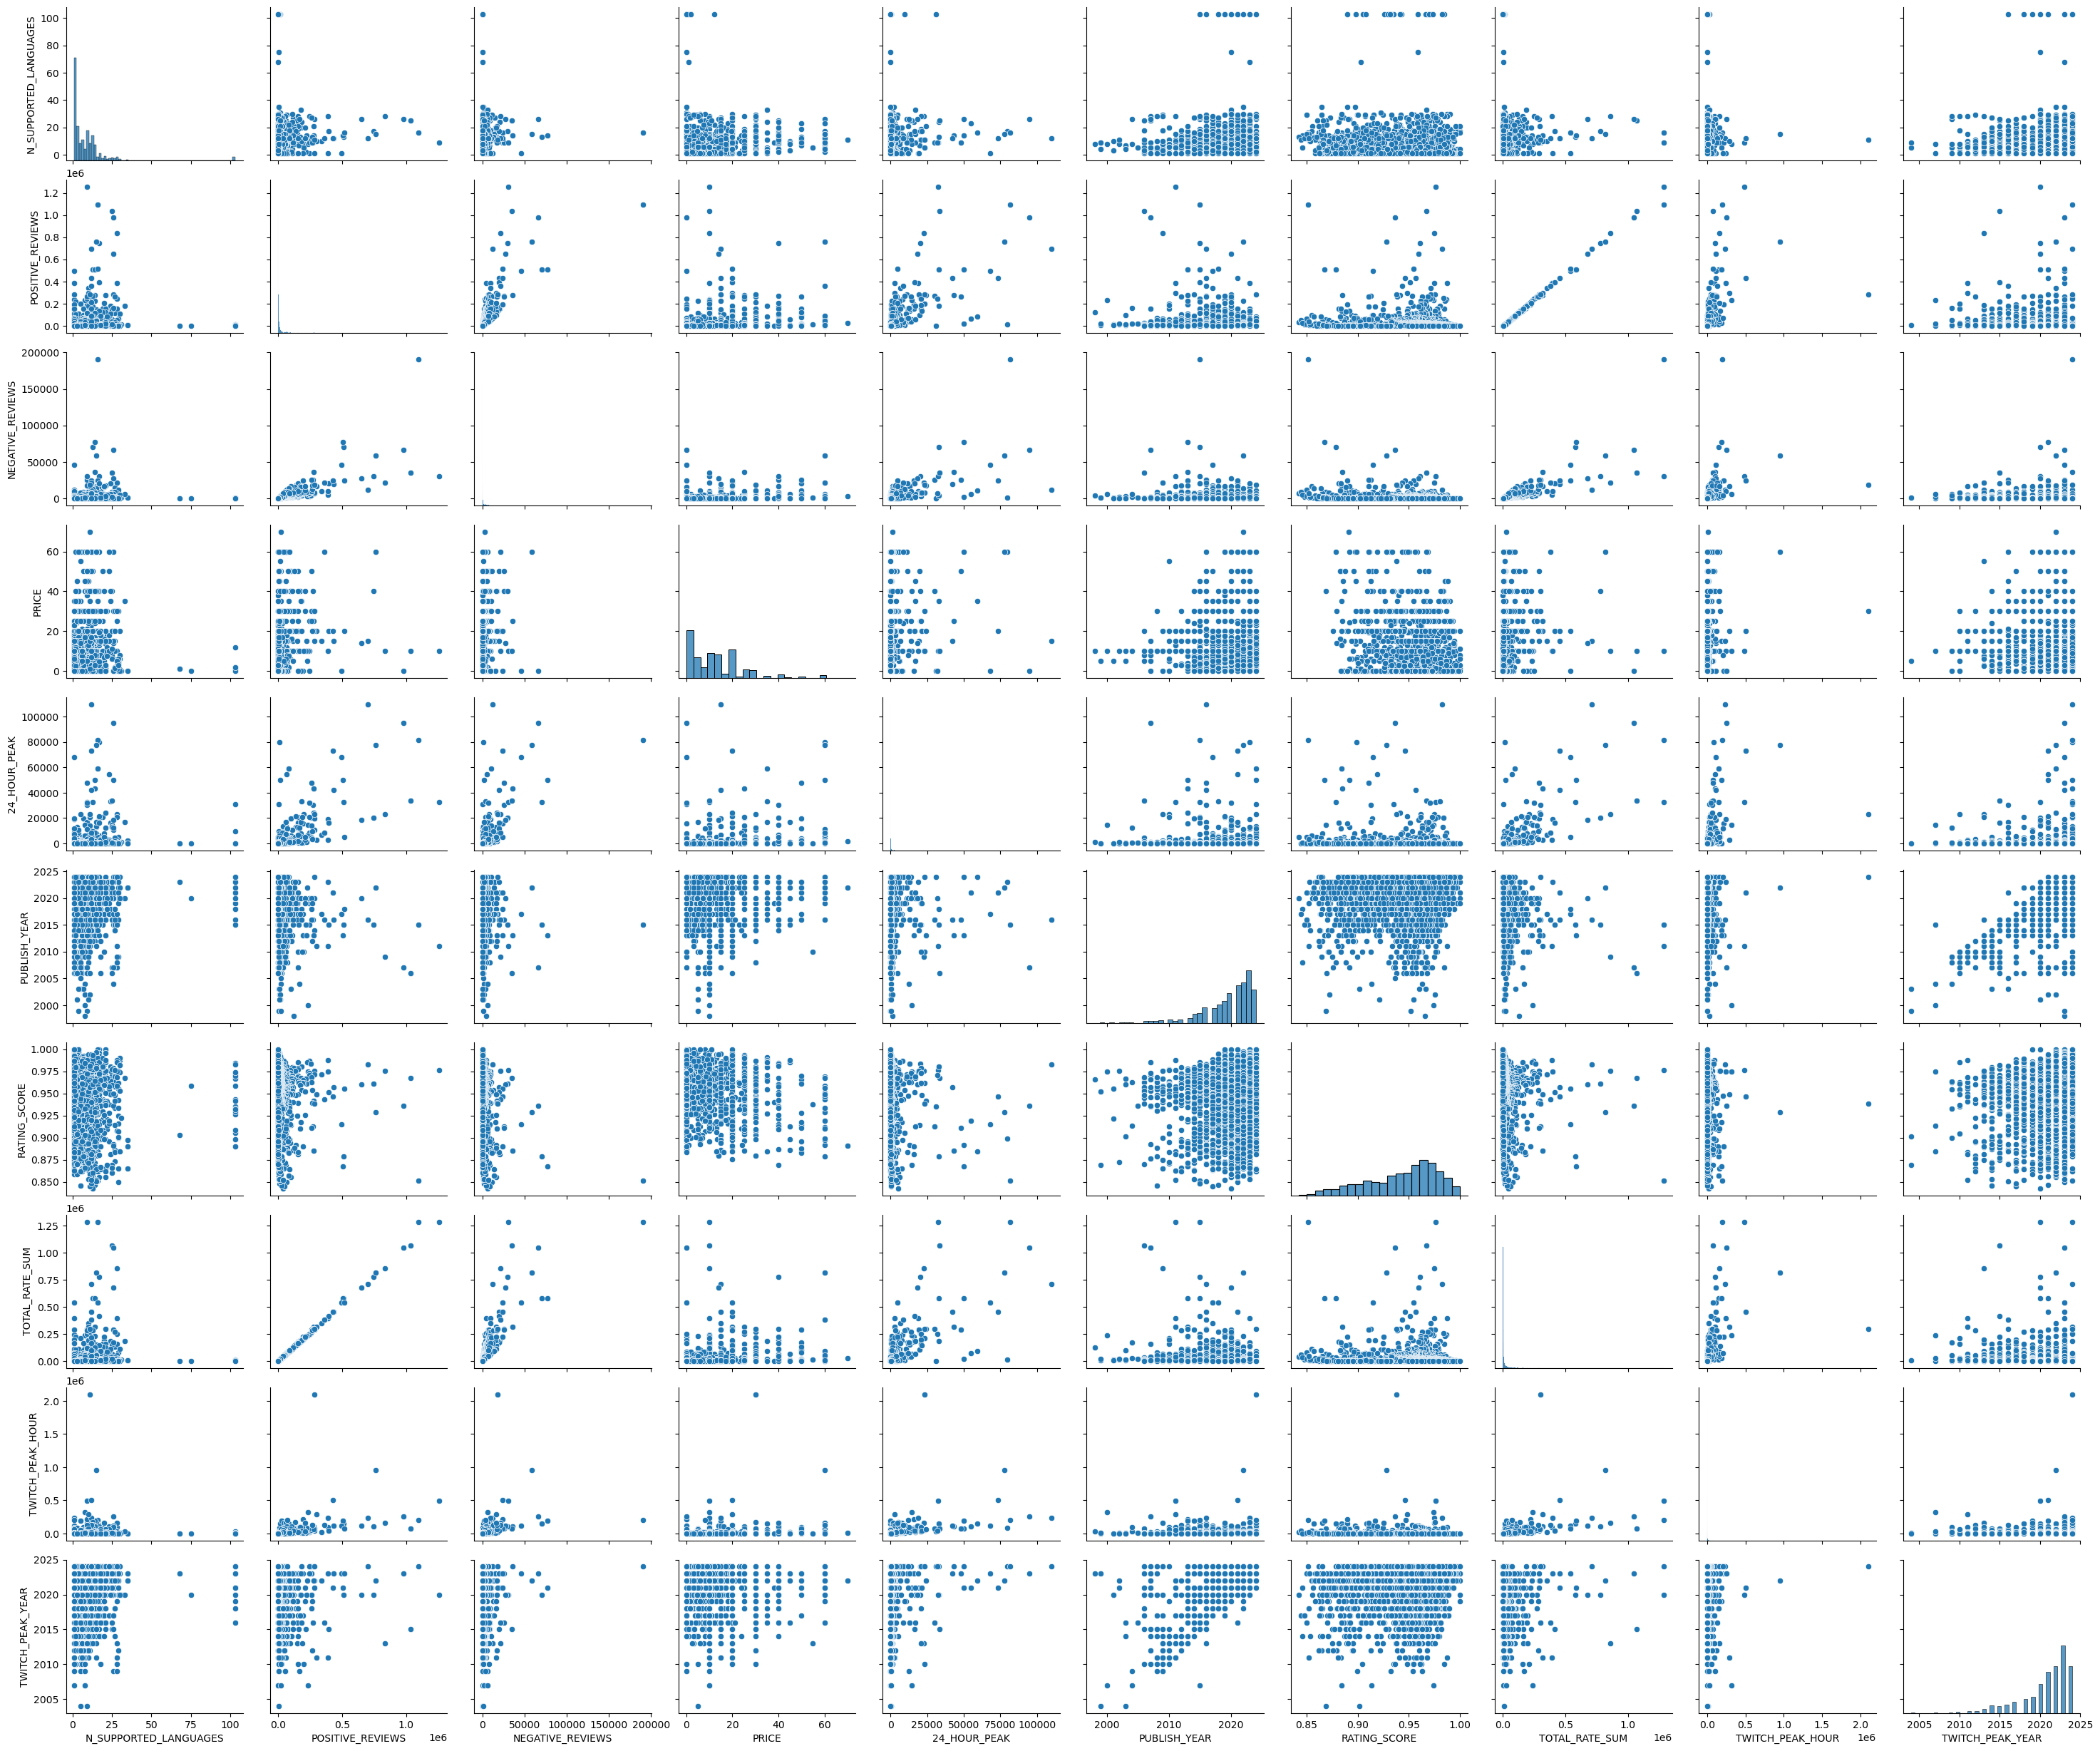

In [19]:
sns.pairplot(df[numerical_features], height=2.5, aspect=1.2)
plt.show()

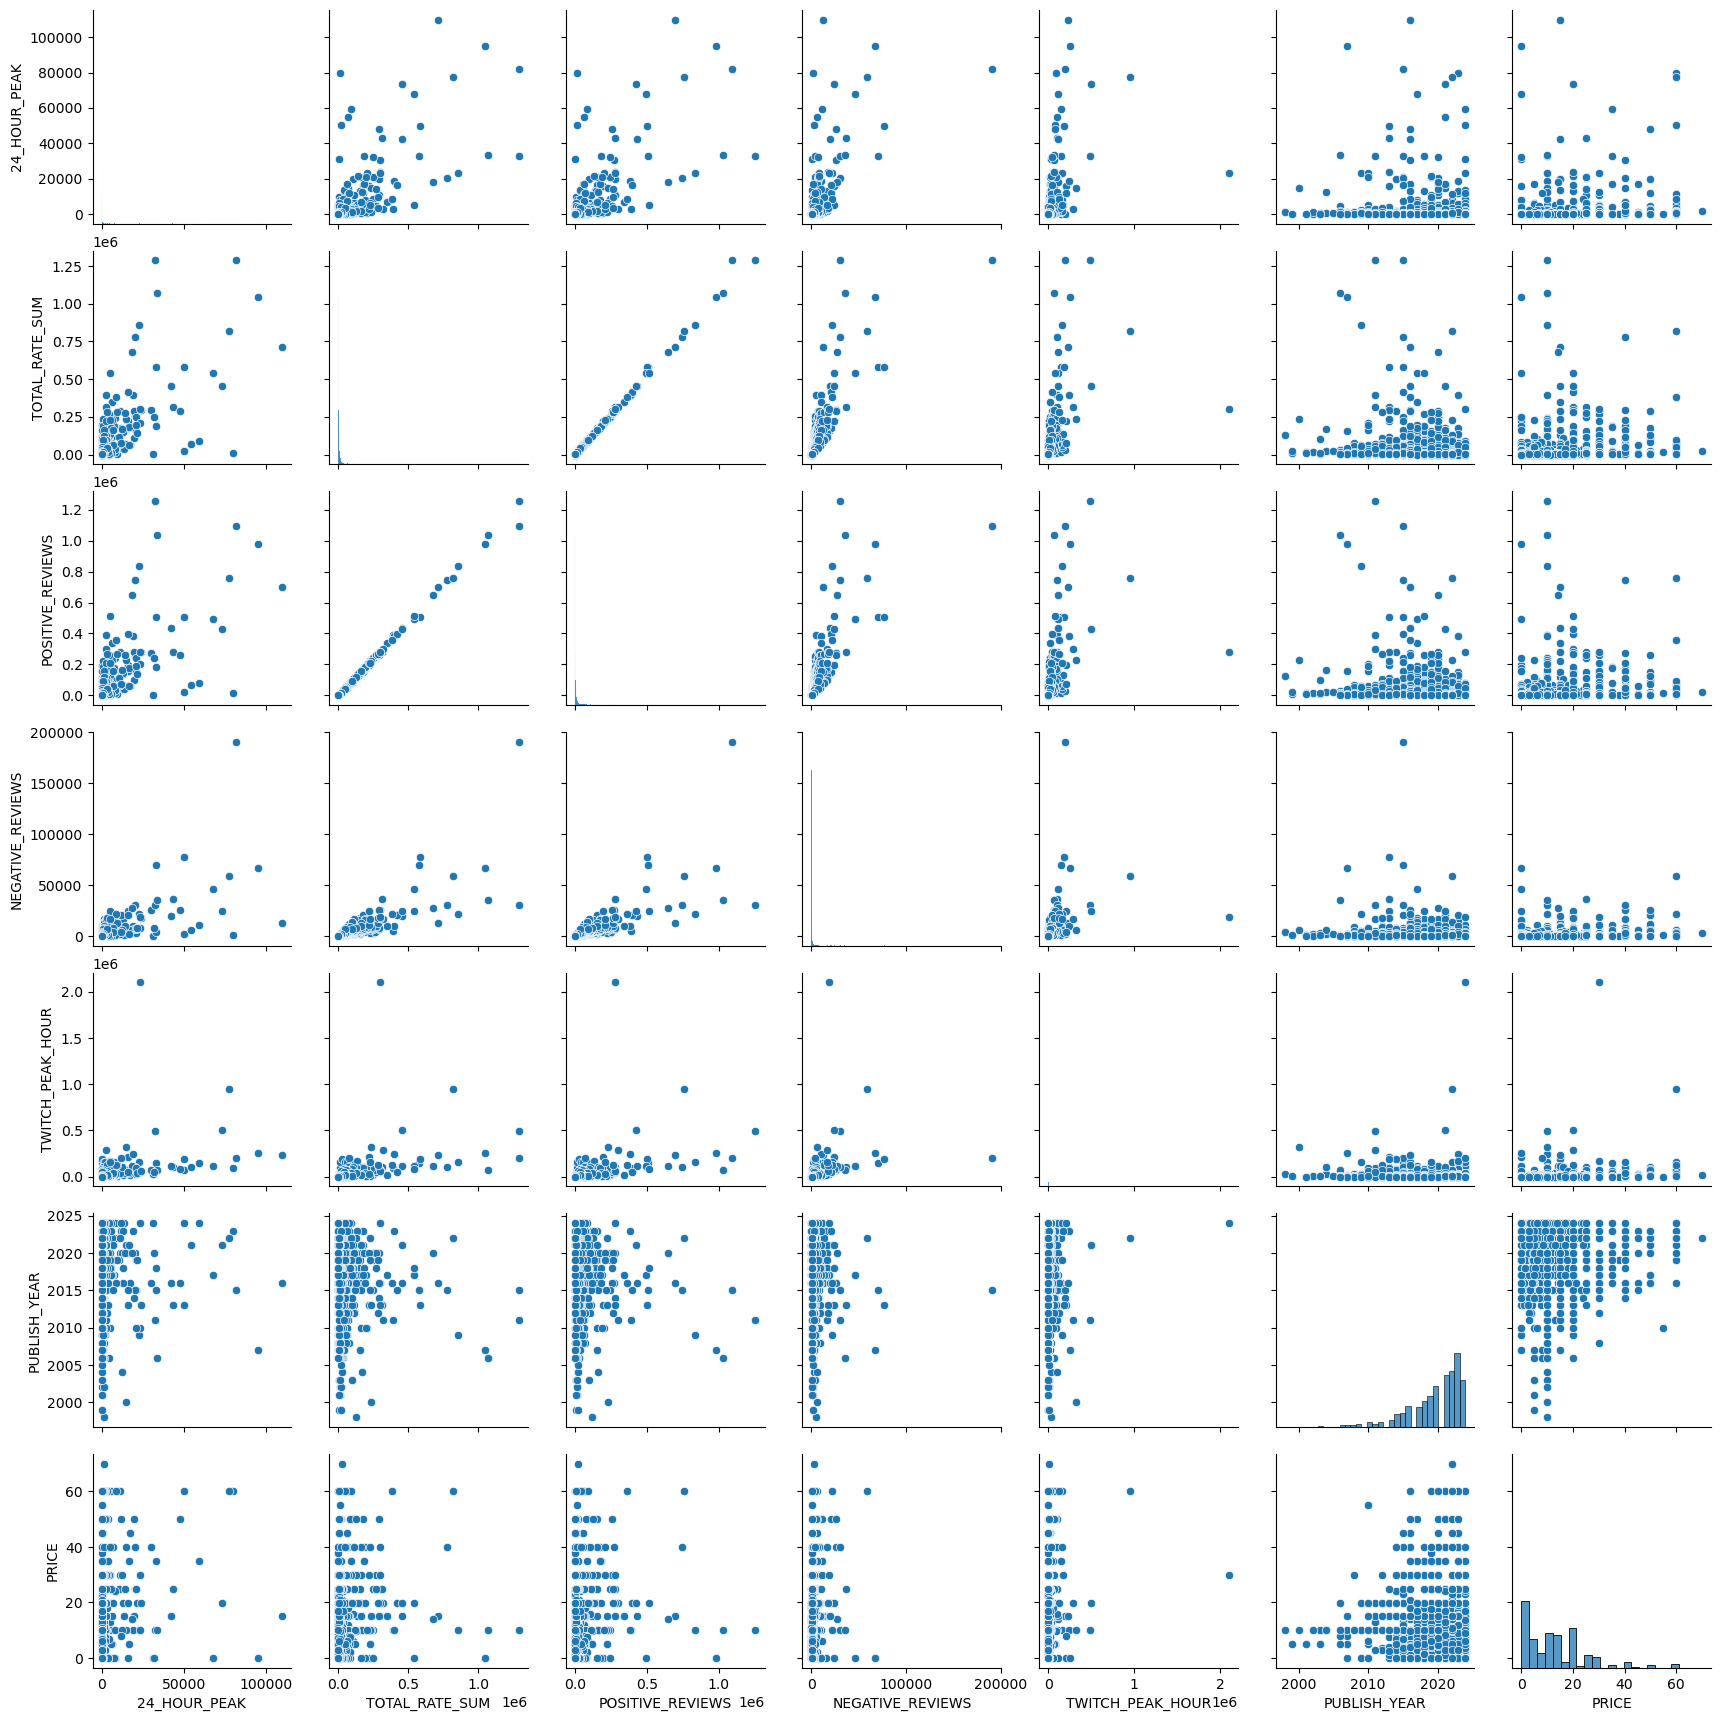

In [20]:
selected_features = ['24_HOUR_PEAK', 'TOTAL_RATE_SUM', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TWITCH_PEAK_HOUR', 'PUBLISH_YEAR', 'PRICE']

sns.pairplot(df[selected_features])
plt.show()

## Summary statistics for the `24_HOUR_PEAK` column

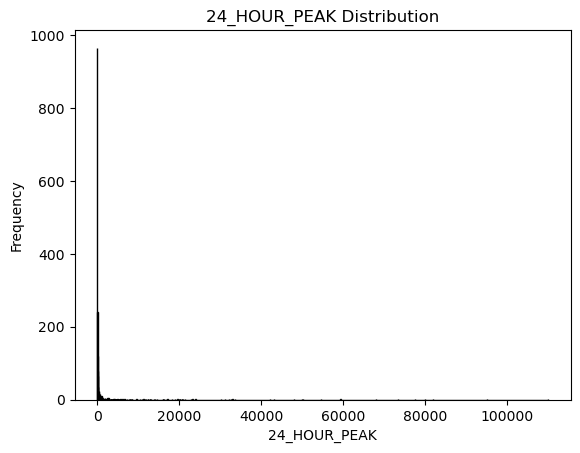

In [21]:
plt.hist(df['24_HOUR_PEAK'], bins='auto', color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.xlabel('24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.title('24_HOUR_PEAK Distribution')
plt.show()

In [22]:
df['24_HOUR_PEAK'].describe()

count      2032.000000
mean       1185.736713
std        6441.760299
min           0.000000
25%          10.000000
50%          36.500000
75%         210.000000
max      109950.000000
Name: 24_HOUR_PEAK, dtype: float64

## Log Transformation (`24_HOUR_PEAK`)

In [23]:
if 'log_24_HOUR_PEAK' not in df.columns:
    df['log_24_HOUR_PEAK'] = np.log1p(df['24_HOUR_PEAK'])
    numerical_features.append('log_24_HOUR_PEAK')

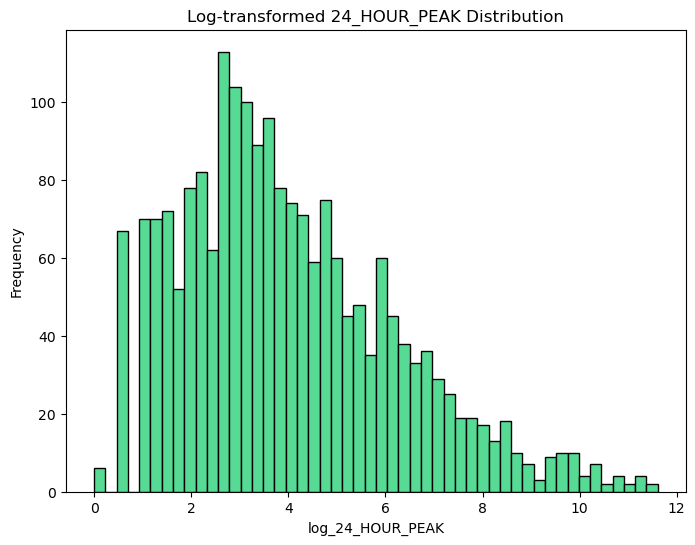

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(df['log_24_HOUR_PEAK'], bins=50, color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.title('Log-transformed 24_HOUR_PEAK Distribution')
plt.xlabel('log_24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.show()

In [25]:
df['log_24_HOUR_PEAK'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2032 entries, 0 to 2031
Series name: log_24_HOUR_PEAK
Non-Null Count  Dtype  
--------------  -----  
2032 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [26]:
df['log_24_HOUR_PEAK'].isnull().sum()

0

## Summary statistics for the `PRICE` column

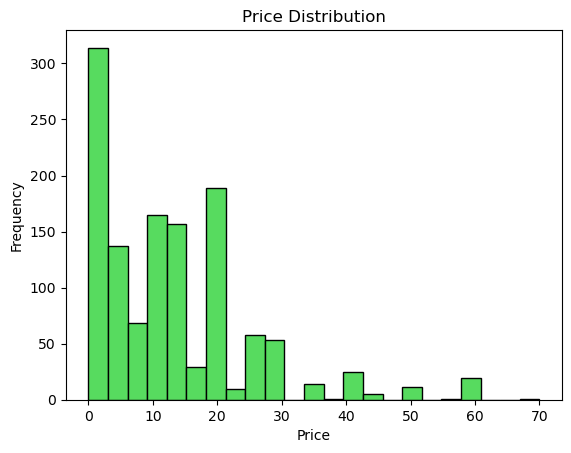

In [27]:
plt.hist(df['PRICE'], bins='auto', color=feature_color_map['PRICE'], edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

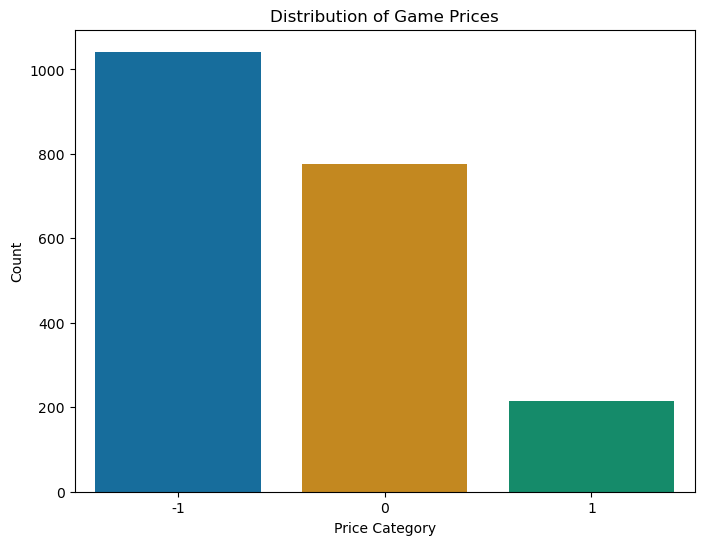

In [28]:
def categorize_price(price):
    if pd.isna(price):
        return 0
    elif price == 0:
        return 1
    else:
        return -1

df = df.assign(PRICE_CATEGORY=df['PRICE'].apply(categorize_price))

price_category_counts = df['PRICE_CATEGORY'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=price_category_counts.index, y=price_category_counts.values, palette='colorblind')

plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Game Prices')
plt.show()


In [29]:
df['PRICE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2032 entries, 0 to 2031
Series name: PRICE
Non-Null Count  Dtype  
--------------  -----  
1257 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [30]:
df['PRICE'].describe()

count    1257.000000
mean       13.113294
std        12.243899
min         0.000000
25%         3.190000
50%         9.990000
75%        19.990000
max        69.990000
Name: PRICE, dtype: float64

In [31]:
df['PRICE'].isnull().sum()

775

##  Summary statistics for the `PUBLISH_YEAR` column

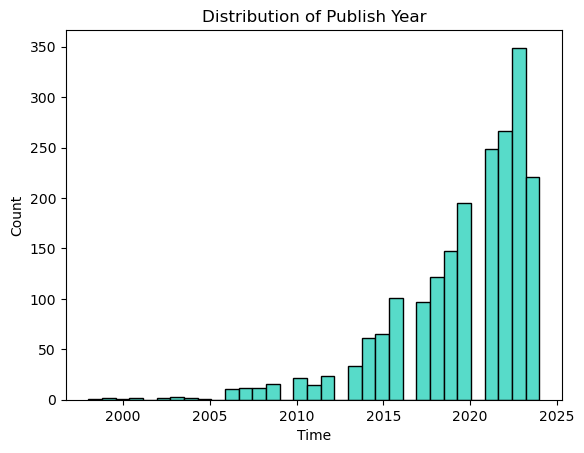

In [32]:
plt.hist(df['PUBLISH_YEAR'], bins='auto', color=feature_color_map['PUBLISH_YEAR'], edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Publish Year')
plt.show()

In [33]:
df['PUBLISH_YEAR'].describe()

count    2032.000000
mean     2019.641240
std         4.081244
min      1998.000000
25%      2018.000000
50%      2021.000000
75%      2023.000000
max      2024.000000
Name: PUBLISH_YEAR, dtype: float64

## Plot the average `24_HOUR_PEAK` for each year (`PUBLISH_YEAR`)

In [34]:
print(sorted(df["PUBLISH_YEAR"].unique()))

[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


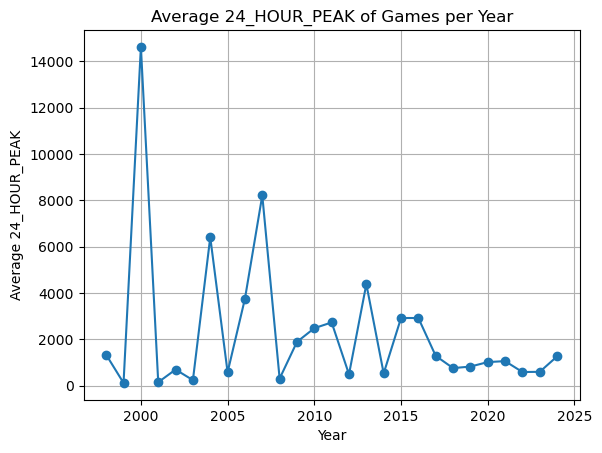

In [35]:
average_peak24_per_year = df.groupby('PUBLISH_YEAR')['24_HOUR_PEAK'].mean()

plt.plot(average_peak24_per_year.index, average_peak24_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average 24_HOUR_PEAK')
plt.title('Average 24_HOUR_PEAK of Games per Year')
plt.grid(True)
plt.show()

## `Platform` Analysis

OS: Linux 2034.064833005894
OS: Windows 1185.7367125984251
OS: macOS 1597.2536520584329


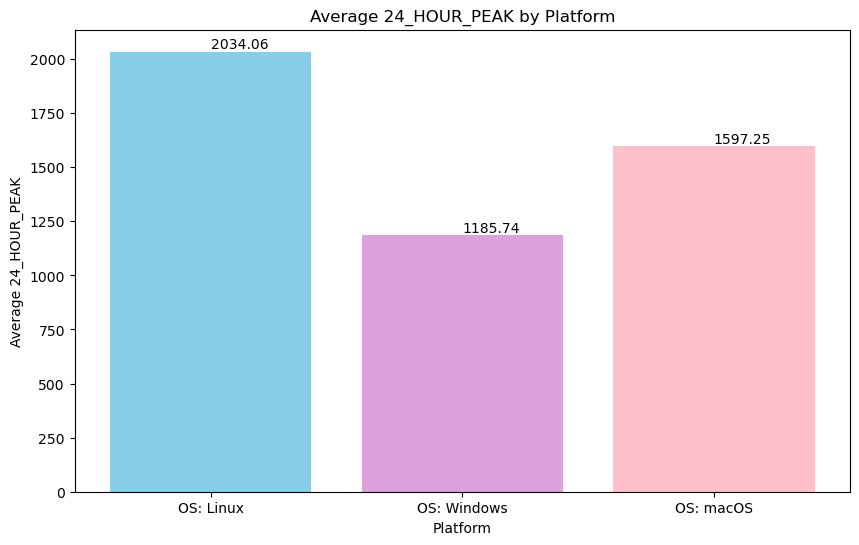

In [36]:
averages = []
for platform in platforms:
    avg = df.loc[df[platform] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(platform, avg)
colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.bar(platforms, averages, color=colors)

for bar, avg in zip(bars, averages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(avg, 2), va='bottom')  # va: vertical alignment

plt.title('Average 24_HOUR_PEAK by Platform')
plt.xlabel('Platform')
plt.ylabel('Average 24_HOUR_PEAK')
plt.show()

del averages


In [37]:
df['PLATFORM_COUNT'] = df[platforms].sum(axis=1)
numerical_features.append('PLATFORM_COUNT')

platform_groups = df.groupby('PLATFORM_COUNT').agg({
    '24_HOUR_PEAK': 'mean'
})

platform_groups.reset_index(inplace=True)

platform_groups

,PLATFORM_COUNT,24_HOUR_PEAK
0,1,891.025556
1,2,1114.720745
2,3,2052.975169


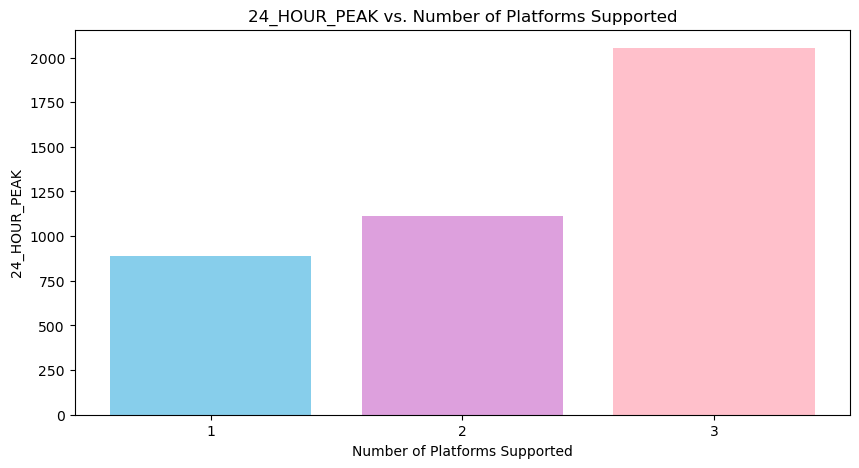

In [38]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(platform_groups['PLATFORM_COUNT'], platform_groups[metric], color=colors)
    plt.xlabel('Number of Platforms Supported')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Number of Platforms Supported')
    plt.xticks(range(1, 4))
    plt.show()

##  Relation between `24_HOUR_PEAK` and `STORE_GENRE`

GENRE: Action 1684.2761104441777
GENRE: Adventure 846.6421052631579
GENRE: Casual 497.15686274509807
GENRE: Early Access 1883.779761904762
GENRE: Free to Play 1593.5118110236222
GENRE: Indie 815.6311475409836
GENRE: Massively Multiplayer 5630.611111111111
GENRE: RPG 2044.4896073903003
GENRE: Racing 1816.388888888889
GENRE: Simulation 1857.577731092437
GENRE: Sports 3348.6666666666665
GENRE: Strategy 1770.7415384615385


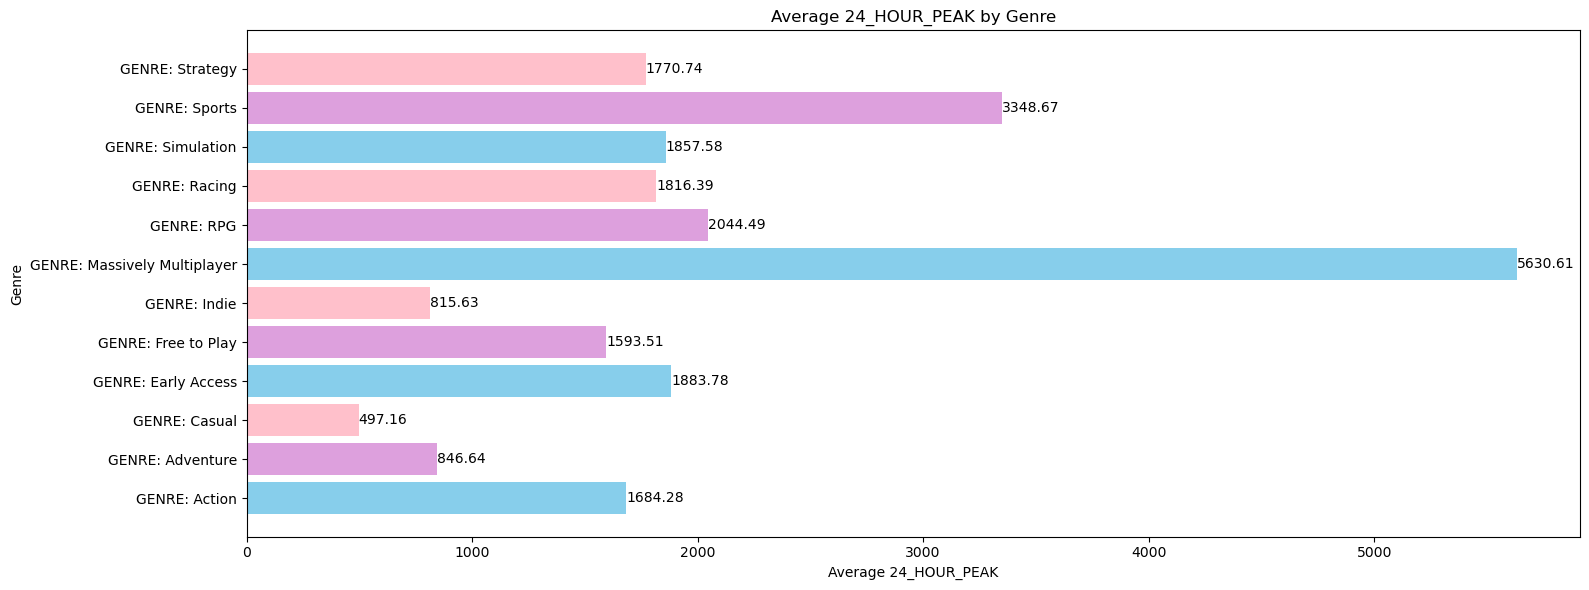

In [39]:

averages = []
for genre in genres:
    avg = df.loc[df[genre] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(genre, avg)

colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(16, 6))
bars = plt.barh(genres, averages, color=colors)

for bar, avg in zip(bars, averages):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2, round(avg, 2), va='center', ha='left')

plt.title('Average 24_HOUR_PEAK by Genre')
plt.ylabel('Genre')
plt.xlabel('Average 24_HOUR_PEAK')
plt.tight_layout()
plt.show()

In [40]:
genres_counts = df[genres].sum()

genres_groups = pd.DataFrame({
    "GENRE": genres_counts.index,
    "GENRE_COUNT": genres_counts.values
})

genres_groups['24_HOUR_PEAK'] = pd.Series([df[df[idx] == 1]['24_HOUR_PEAK'].mean()  for idx in genres_counts.index])

genres_groups

,GENRE,GENRE_COUNT,24_HOUR_PEAK
0,GENRE: Action,833,1684.276110
1,GENRE: Adventure,950,846.642105
2,GENRE: Casual,663,497.156863
3,GENRE: Early Access,168,1883.779762
4,GENRE: Free to Play,254,1593.511811
5,GENRE: Indie,1342,815.631148
6,GENRE: Massively Multiplayer,18,5630.611111
7,GENRE: RPG,433,2044.489607
8,GENRE: Racing,54,1816.388889
9,GENRE: Simulation,476,1857.577731


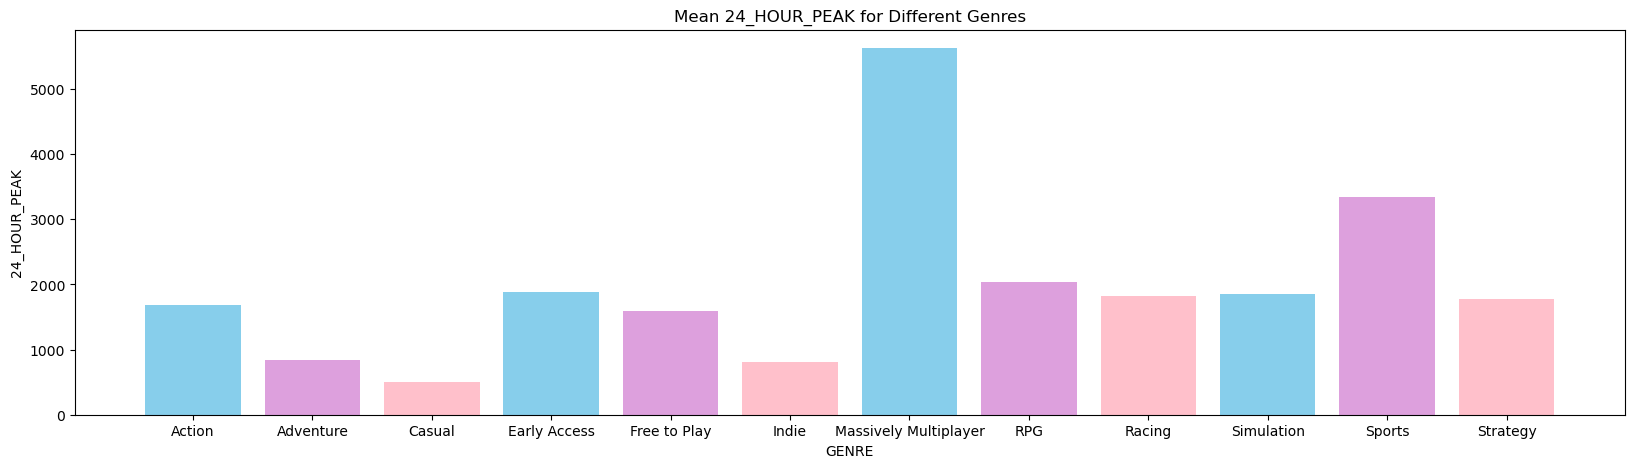

In [41]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(20, 5))
    plt.bar(genres_groups['GENRE'].str.replace('GENRE: ', ''), genres_groups[metric], color=colors)
    plt.xlabel('GENRE')
    plt.ylabel(metric)
    plt.title(f'Mean {metric} for Different Genres')
    plt.show()

## Analyze `REVIEWS` metrics

In [42]:
df.head(1)

,NAME,N_SUPPORTED_LANGUAGES,DEVELOPERS,POSITIVE_REVIEWS,NEGATIVE_REVIEWS,PRICE,24_HOUR_PEAK,PUBLISH_YEAR,RATING_SCORE,TOTAL_RATE_SUM,...,GENRE: Racing,GENRE: Simulation,GENRE: Sports,GENRE: Strategy,OS: Linux,OS: Windows,OS: macOS,log_24_HOUR_PEAK,PRICE_CATEGORY,PLATFORM_COUNT
0,470,7,205,39271,5015,NaN,1064.0,2016,0.886759,44286,...,0,0,0,0,0,1,0,6.97073,0,1


In [43]:
if 'NEGATIVE_REVIEWS_percentage' not in df.columns:
    df['NEGATIVE_REVIEWS_percentage'] = df['NEGATIVE_REVIEWS']/df['TOTAL_RATE_SUM']
    numerical_features.append('NEGATIVE_REVIEWS_percentage')

reviews = ['RATING_SCORE', 'NEGATIVE_REVIEWS_percentage', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TOTAL_RATE_SUM']


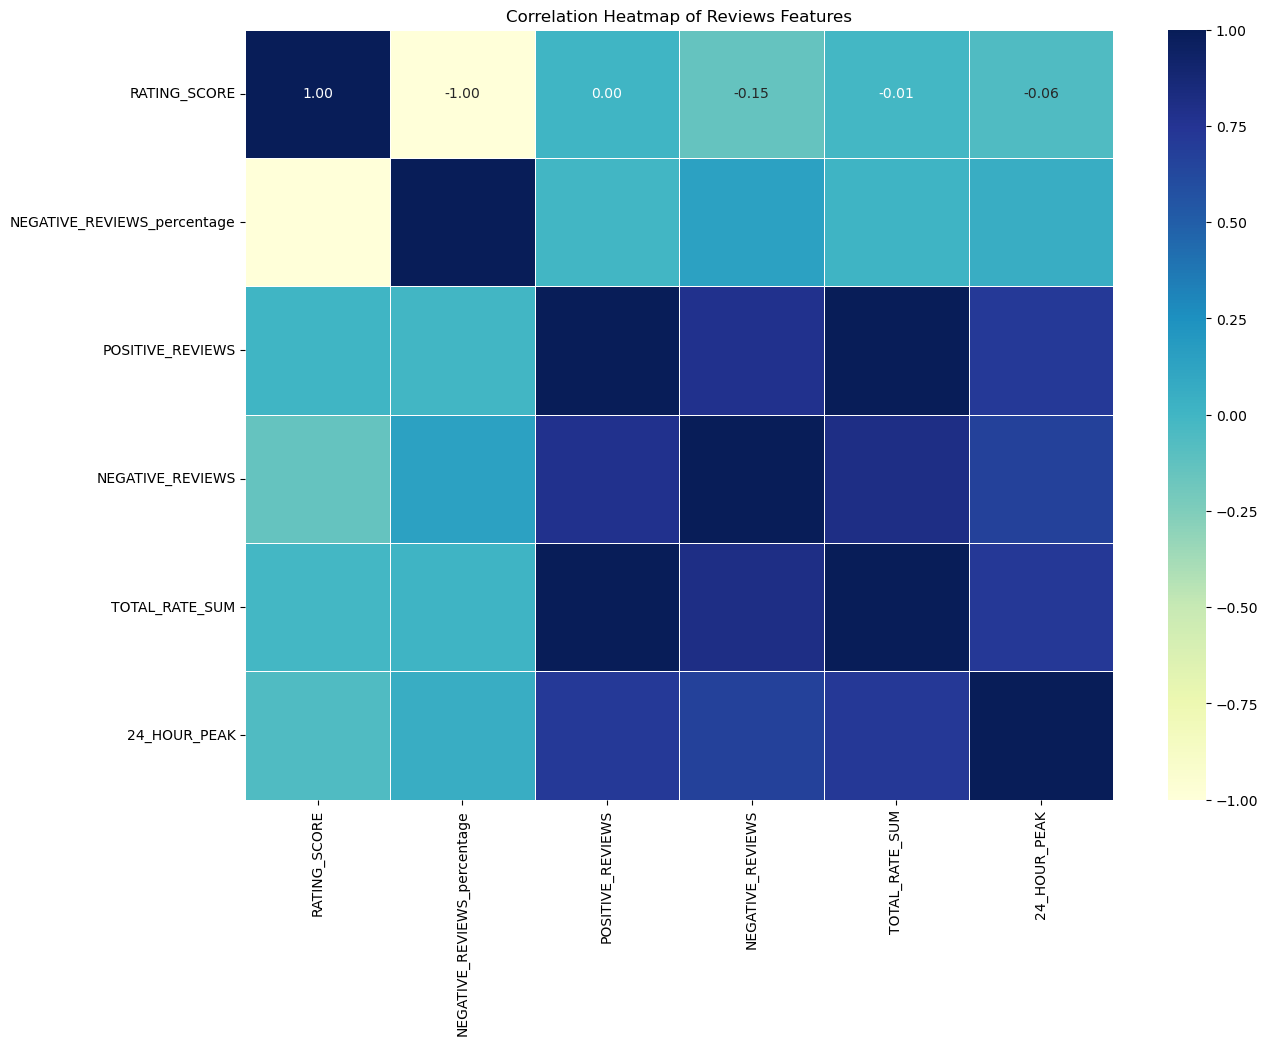

In [44]:
targets = reviews 
targets.append('24_HOUR_PEAK')



correlation_matrix = df[targets].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Reviews Features')
plt.show()

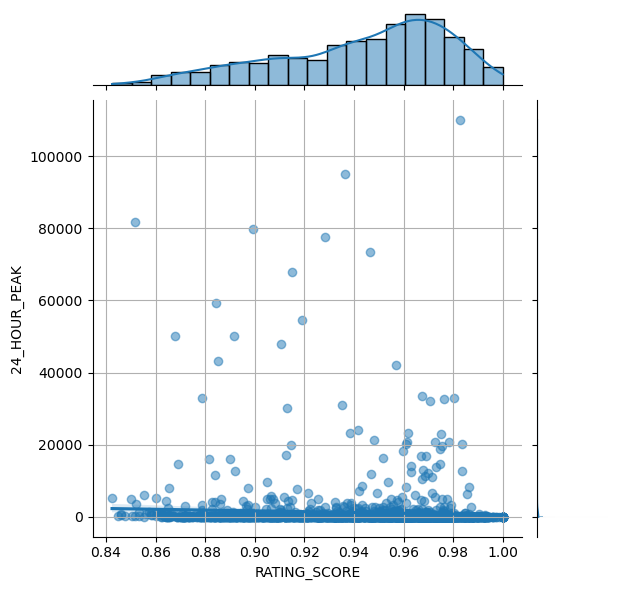

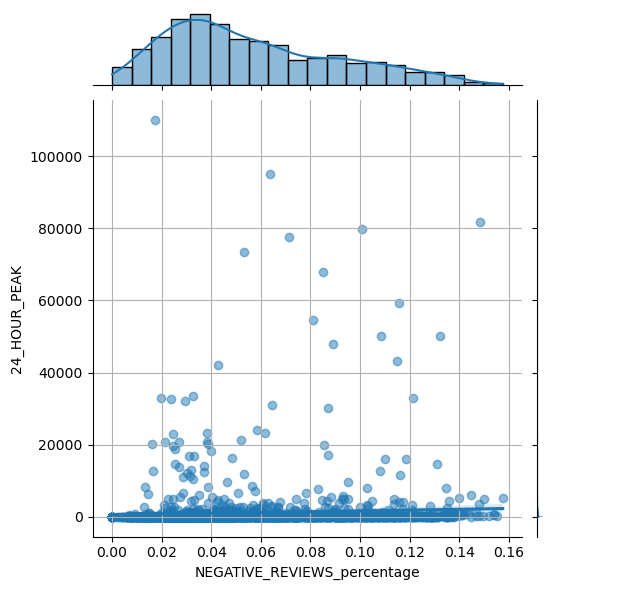

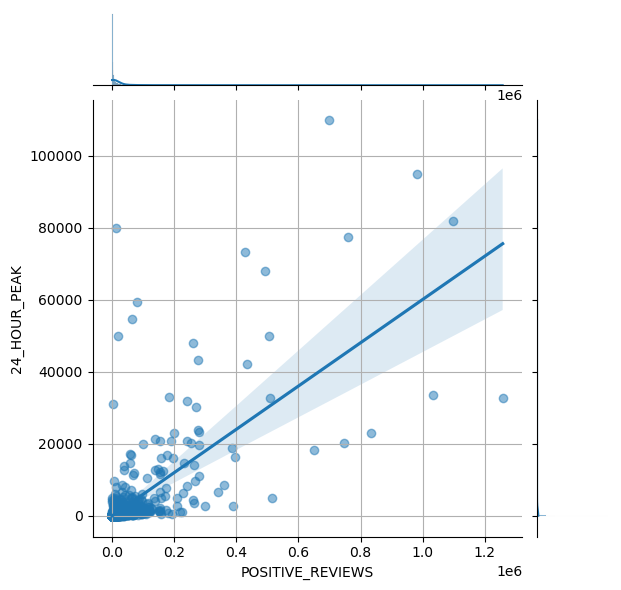

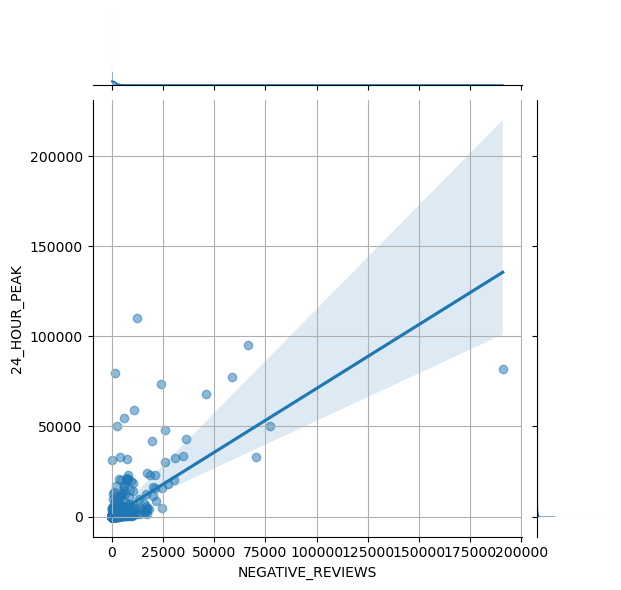

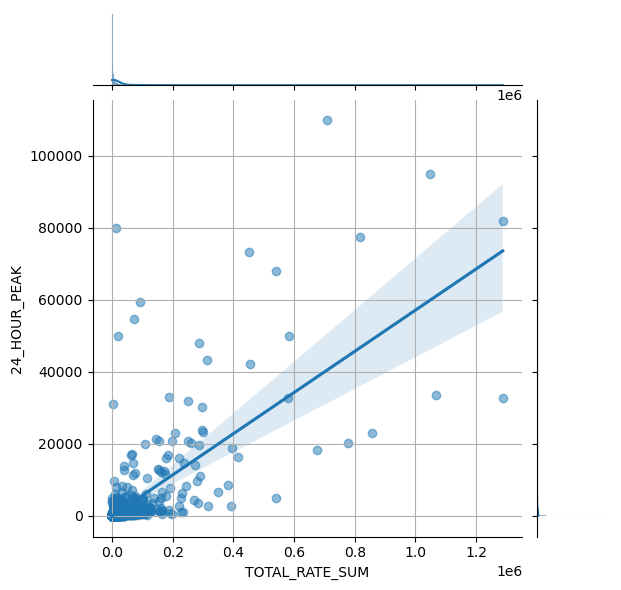

In [45]:
for metric in reviews:
    if metric == '24_HOUR_PEAK':
        continue
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='reg', scatter_kws={'alpha':0.5})
    plt.xlabel(f'{metric}')
    plt.ylabel('24_HOUR_PEAK')
    plt.grid(True)
    plt.show()
    

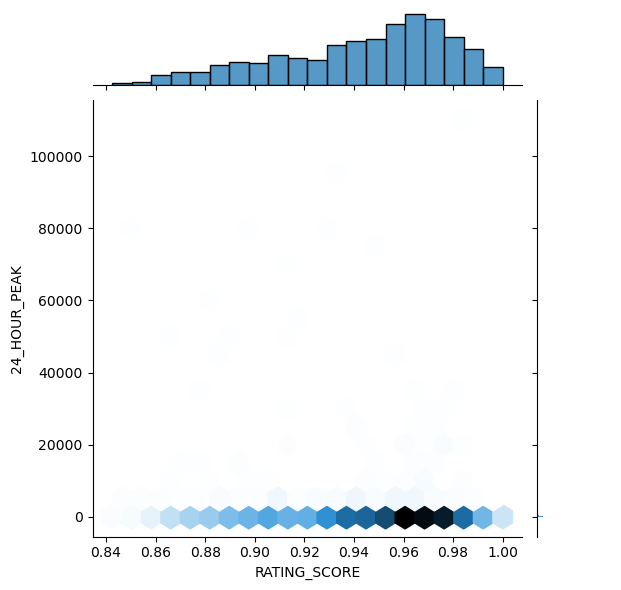

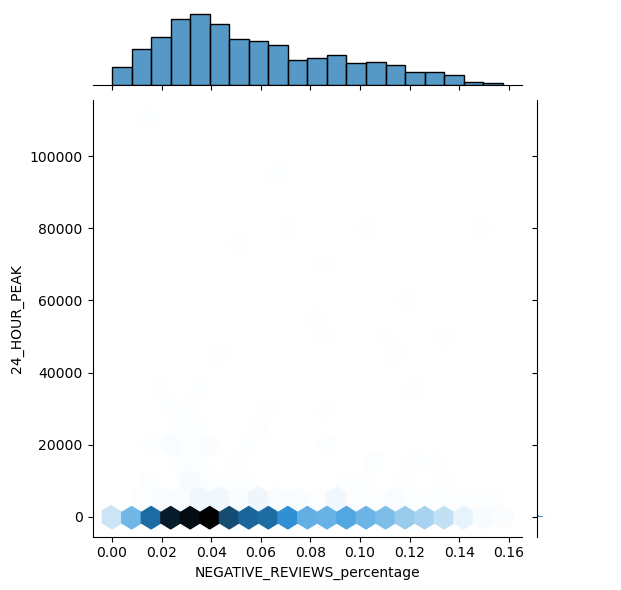

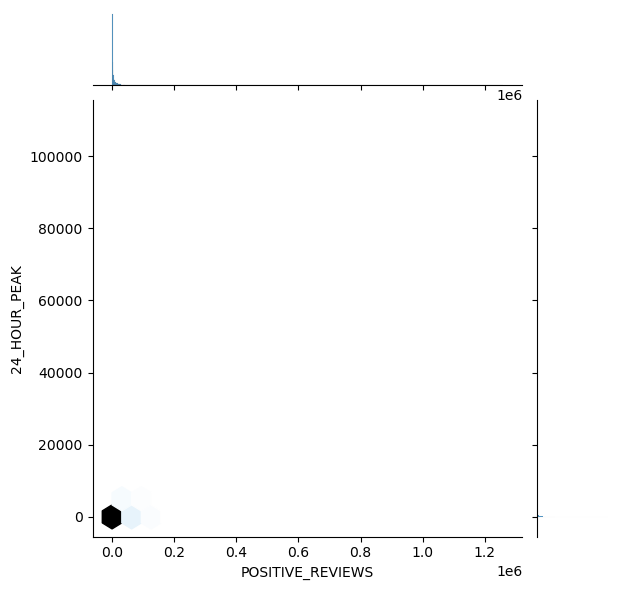

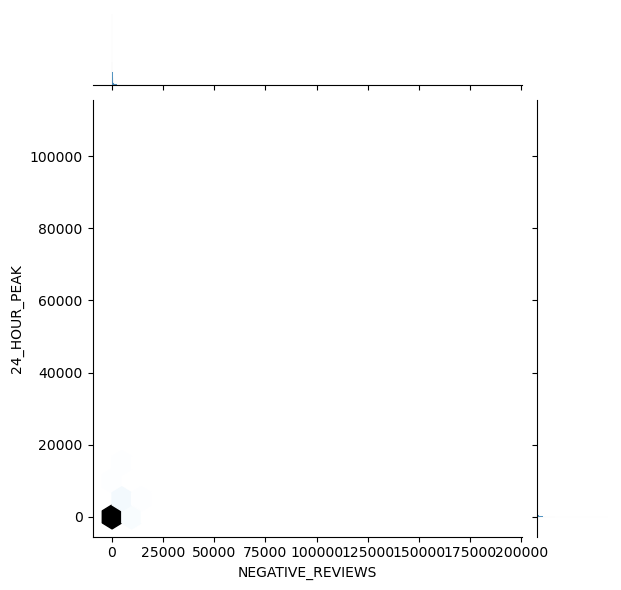

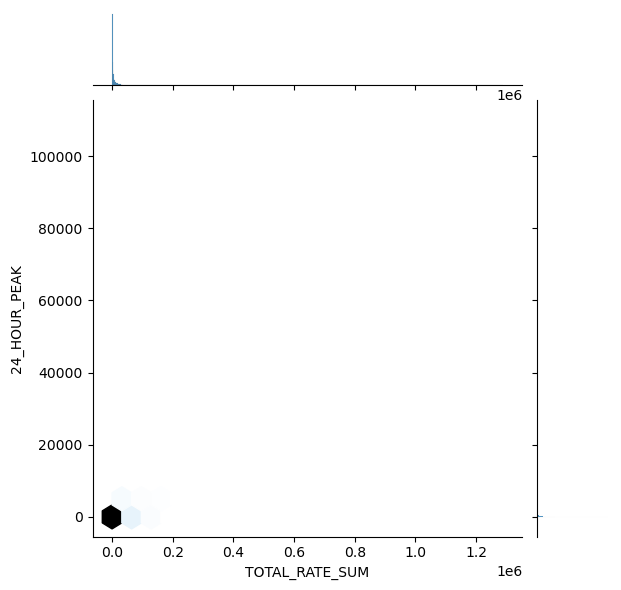

In [46]:
for metric in reviews:
    if metric == '24_HOUR_PEAK':
        continue
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='hex', gridsize=20)
    plt.xlabel(metric)
    plt.ylabel('24_HOUR_PEAK')
    plt.show()


In [47]:
df.query("RATING_SCORE >= 0.99").sort_values(by="RATING_SCORE", ascending=False)[["NAME", "DEVELOPERS", "RATING_SCORE", "24_HOUR_PEAK"]]

,NAME,DEVELOPERS,RATING_SCORE,24_HOUR_PEAK
26,1792,1080,1.000000,2.0
341,658,1610,1.000000,1.0
1967,505,1121,1.000000,1.0
1929,2009,1387,1.000000,1.0
1092,655,63,1.000000,7.0
...,...,...,...,...
1624,1161,441,0.990215,10.0
1257,793,1527,0.990202,26.0
1022,267,1374,0.990148,7.0
938,377,1429,0.990025,26.0


### Developer Analysis

In [48]:
developer_game_count = df['DEVELOPERS'].value_counts()

developer_24_HOUR_PEAK_summary = df.groupby('DEVELOPERS')['24_HOUR_PEAK'].mean().sort_values(ascending=False)

developer_summary = pd.DataFrame({
    'Game Count': developer_game_count,
    'Average 24_HOUR_PEAK': developer_24_HOUR_PEAK_summary
}).dropna().sort_values(by='Game Count', ascending=False)

developer_summary

,Game Count,Average 24_HOUR_PEAK
DEVELOPERS,,
1420,15,10115.800000
1214,14,422.357143
67,11,2.454545
194,10,1256.800000
1583,7,20.714286
...,...,...
681,1,5.000000
680,1,356.000000
679,1,1898.000000


## Correlation Heatmap

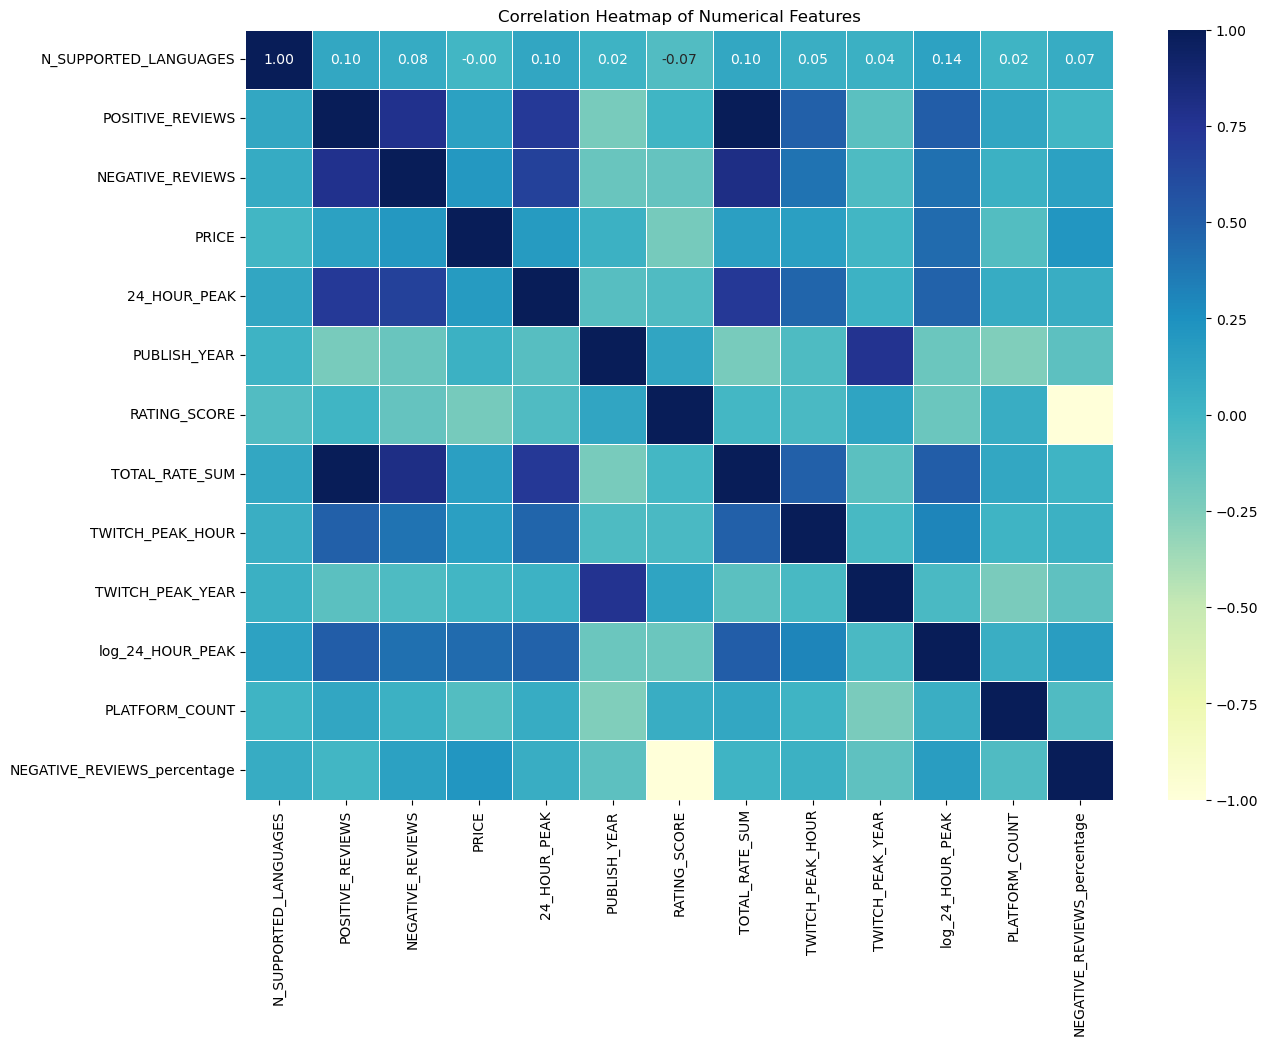

In [49]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

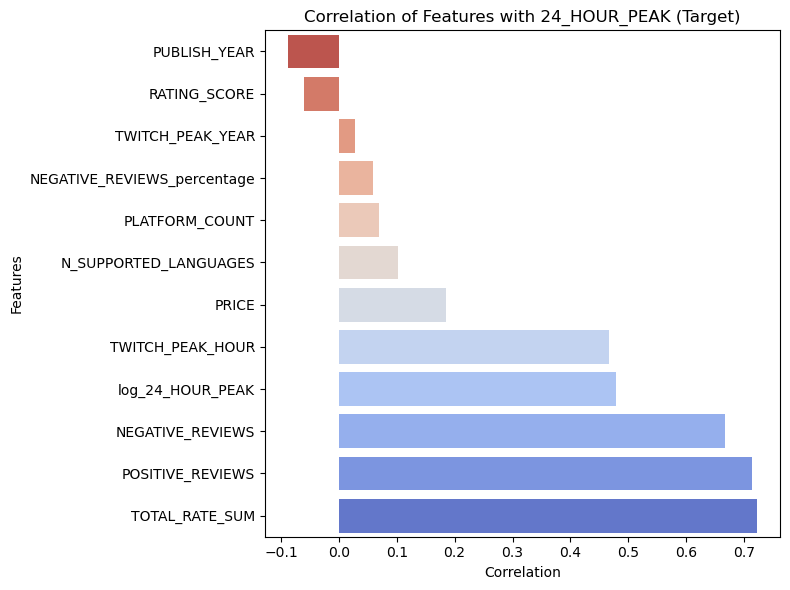

In [50]:
target_correlation = correlation_matrix['24_HOUR_PEAK'].drop('24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


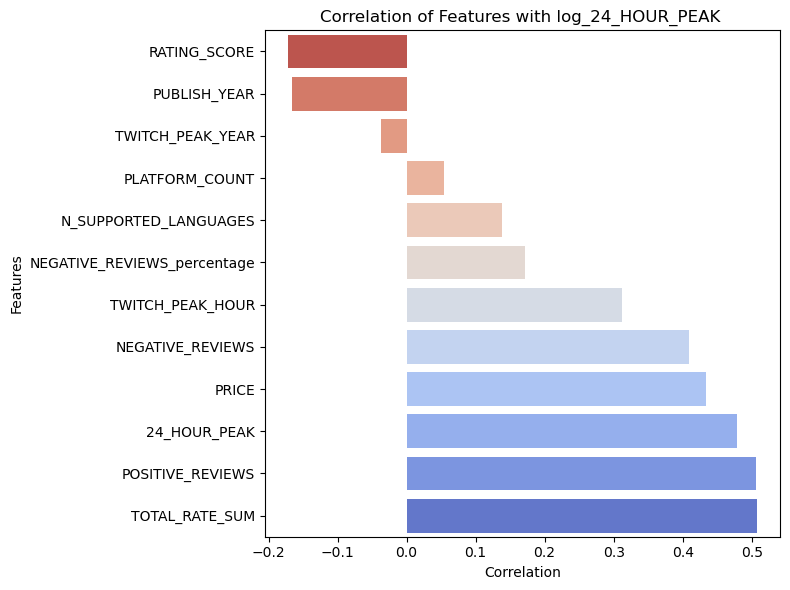

In [51]:
target_correlation = correlation_matrix['log_24_HOUR_PEAK'].drop('log_24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with log_24_HOUR_PEAK ')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


# Evaluation Metric

Choose appropriate evaluation metrics based on the nature of the data and the project goal, and **explain your reasons for choosing them.**

In [52]:
def analysis_model(history, model, X_train, y_train, X_val, y_val, title='Model Performance'):
    if history is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_absolute_error'], label='Train MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
        plt.title('Model Mean Absolute Error')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.show()
    
    # Predictions for train and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics for training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
    
    # Calculate metrics for validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    
    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame({
        'Set': ['Training', 'Validation'],
        'Loss': [train_loss, val_loss],
        'RMSE': [train_rmse, val_rmse],
        'R-squared': [train_r2, val_r2],
        'MAE': [train_mae, val_mae]
    })
    
    print(f'{title} - Evaluation Metrics:')
    return metrics_df

# Feature Selection

In [54]:
target_y = 'log_24_HOUR_PEAK'

In [55]:
if '24_HOUR_PEAK' in df.columns:
    df = df.drop(columns='24_HOUR_PEAK')
    numerical_features.remove('24_HOUR_PEAK')

In [56]:
if technologies[0] in df.columns:
    df = df.drop(columns=technologies)

In [57]:
if 'PRICE' in df.columns:    
    df = df.drop(columns = "PRICE")
    numerical_features.remove('PRICE')

In [58]:
if 'PRICE_CATEGORY' in df.columns:    
    df = df.drop(columns = "PRICE_CATEGORY")

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NAME                          2032 non-null   int32  
 1   N_SUPPORTED_LANGUAGES         2032 non-null   int64  
 2   DEVELOPERS                    2032 non-null   int32  
 3   POSITIVE_REVIEWS              2032 non-null   int64  
 4   NEGATIVE_REVIEWS              2032 non-null   int64  
 5   PUBLISH_YEAR                  2032 non-null   int64  
 6   RATING_SCORE                  2032 non-null   float64
 7   TOTAL_RATE_SUM                2032 non-null   int64  
 8   TWITCH_PEAK_HOUR              2032 non-null   float64
 9   TWITCH_PEAK_YEAR              2032 non-null   int64  
 10  GENRE: Action                 2032 non-null   int64  
 11  GENRE: Adventure              2032 non-null   int64  
 12  GENRE: Casual                 2032 non-null   int64  
 13  GEN

**Remove highly correlated features (correlation coefficient > 0.9)**

In [60]:
correlation_matrix = df[numerical_features].corr()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(high_correlation)
df = df.drop(columns=high_correlation)
df_reduced = df

['TOTAL_RATE_SUM']


**SelectKBest to select top features based on f_regression**

In [101]:
# Temporary testing code - not used in final implementation
X = df_reduced.drop(target_y, axis=1)
y = df_reduced[target_y]
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")


Selected features: Index(['POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'PUBLISH_YEAR', 'RATING_SCORE',
       'TWITCH_PEAK_HOUR', 'GENRE: Casual', 'GENRE: Indie',
       'GENRE: Simulation', 'GENRE: Strategy', 'NEGATIVE_REVIEWS_percentage'],
      dtype='object')


In [148]:
df_selected = df_reduced[selected_features].copy()
df_selected[target_y] = y

# Split the dataset into training and testing sets (`df_selected`)

In [162]:
X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected.drop(target_y, axis=1), df_selected[target_y], test_size=0.2, random_state=42)

# Standardization (`df_selected`)

In [163]:
scaler = StandardScaler()

X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

## Testing Our Features

In [165]:
model = Sequential([
    Input(shape=(X_train_selected_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(Adam(learning_rate=.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_selected_scaled, y_train, epochs=60, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13.2279 - mean_absolute_error: 2.9728 - val_loss: 10.6806 - val_mean_absolute_error: 1.6781
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8060 - mean_absolute_error: 1.5822 - val_loss: 9.9293 - val_mean_absolute_error: 1.6025
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7995 - mean_absolute_error: 1.4829 - val_loss: 10.3475 - val_mean_absolute_error: 1.5781
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0865 - mean_absolute_error: 1.3808 - val_loss: 10.1013 - val_mean_absolute_error: 1.5615
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0463 - mean_absolute_error: 1.4021 - val_loss: 11.8565 - val_mean_absolute_error: 1.5770
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8395 - mean_absolute_error: 1.3370 - val_loss: 10.1073 - val_mean_absolute_error: 1.5366
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6586 - mean_absolute_error: 1.3107 - val_loss:

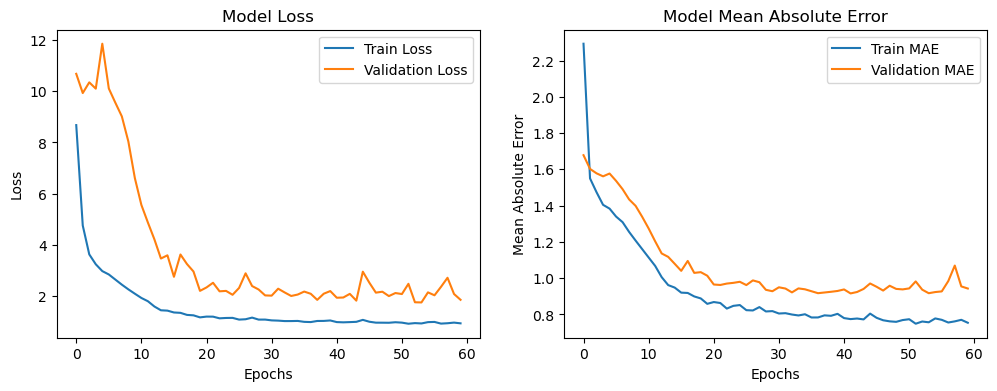

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model Performance - Evaluation Metrics:


,Set,Loss,RMSE,R-squared,MAE
0,Training,0.884346,0.940397,0.815632,0.734524
1,Validation,1.853632,1.361482,0.626424,0.943009


In [166]:
# Evaluate the model
X_val_scaled = X_train_selected_scaled[int(len(X_train_selected_scaled) * 0.8):]  # Last 20% as validation set
y_val = y_train[int(len(y_train) * 0.8):]  # Last 20% as validation set

analysis_model(history, model, X_train_selected_scaled[:int(len(X_train_selected_scaled) * 0.8)], y_train[:int(len(y_train) * 0.8)], X_val_scaled, y_val)

# Split the dataset into training and testing sets (`df`)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_y, axis=1), df_selected[target_y], test_size=0.2, random_state=42)

# Standardization (`df`)

In [168]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction

Using the PCA method, reduce the dimensions of numerical features to two dimensions. 


How much of the initial data variance is transferred to the new space?

If we aim to retain 95% of the original variance, what is the minimum number of dimensio s
required in the new space? Save both the original data and the dimension-reduced one  or
the next parts.

In [169]:
pca_95 = PCA(n_components=0.95)
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_test_pca_95 = pca_95.transform(X_test_scaled)
print(f"Number of components to retain 95% variance: {pca_95.n_components_}")

Number of components to retain 95% variance: 20


In [170]:
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
print(f"2 components retain {pca_2d.noise_variance_ * 100}% variance")

2 components retain 81.33448024206226% variance


In [171]:
X_train_pca_2d

array([[ 2.46454076, -1.87104167],
       [ 1.24655315,  0.20875852],
       [-1.40435903, -0.78105414],
       ...,
       [-0.8493848 , -0.46042315],
       [-1.67878547, -1.38134235],
       [ 4.61345386,  2.10117031]])

# Model Training

In this section, you need to implement three methods to predict your target variable.   
First, split the initial data (including all features) into training and test sets.

## Create the XGBoost regressor object

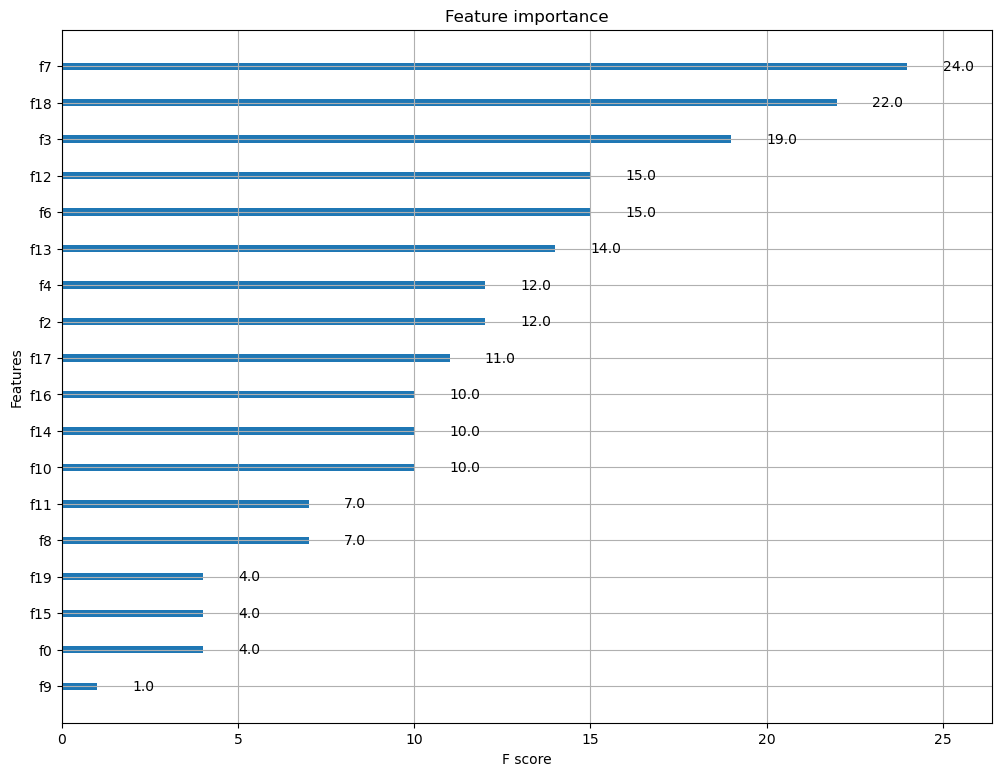

In [172]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the regressor to the training set
xg_reg.fit(X_train_pca_95, y_train)

# Plot the feature importance
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 9]
plt.show()

## Method One:  Neural Network

In [175]:
model = Sequential([
    Input(shape=(X_train_pca_95.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(Adam(learning_rate=.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_pca_95, y_train, epochs=60, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12.2155 - mean_absolute_error: 2.7785 - val_loss: 4.7646 - val_mean_absolute_error: 1.6126
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7727 - mean_absolute_error: 1.5532 - val_loss: 5.1587 - val_mean_absolute_error: 1.5178
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3622 - mean_absolute_error: 1.4618 - val_loss: 5.4848 - val_mean_absolute_error: 1.4902
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1701 - mean_absolute_error: 1.3914 - val_loss: 6.0964 - val_mean_absolute_error: 1.4801
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2286 - mean_absolute_error: 1.3977 - val_loss: 6.4987 - val_mean_absolute_error: 1.4798
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5275 - mean_absolute_error: 1.2820 - val_loss: 6.1301 - val_mean_absolute_error: 1.4764
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8398 - mean_absolute_error: 1.3363 - val_loss: 7.29

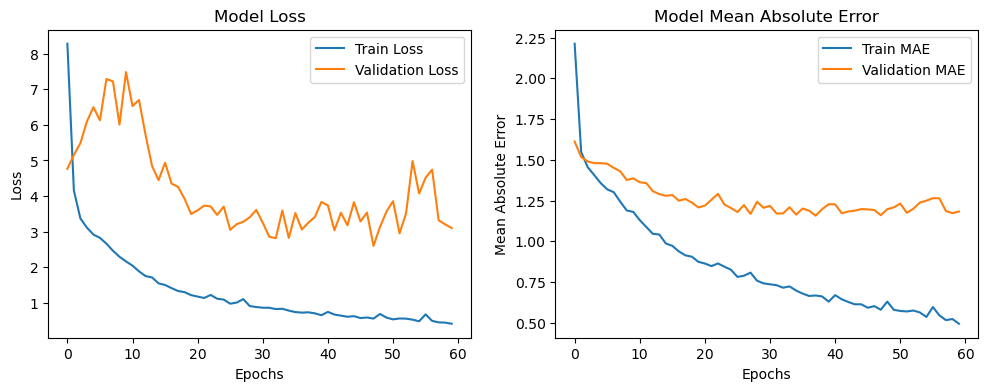

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model Performance - Evaluation Metrics:


,Set,Loss,RMSE,R-squared,MAE
0,Training,0.396377,0.629585,0.917363,0.494883
1,Validation,3.098834,1.760351,0.375469,1.183119


In [176]:
# Evaluate the model
X_val_scaled = X_train_pca_95[int(len(X_train_pca_95) * 0.8):]  # Last 20% as validation set
y_val = y_train[int(len(y_train) * 0.8):]  # Last 20% as validation set

analysis_model(history, model, X_train_pca_95[:int(len(X_train_pca_95) * 0.8)], y_train[:int(len(y_train) * 0.8)], X_val_scaled, y_val)

In [184]:
table_cols = ['# of units per layer', '# of epochs', 'Size of batches']
table2 = pd.DataFrame(columns = table_cols)

param_sets = [[16,32,64],[256,200,16],[16,200,16],[16,128,16]]
# create and train a model for each parameter set
for ps in param_sets:
    # create model
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(rate=0.4),
        Dense(ps[0], activation='relu'),
        Dense(1, activation='relu')
    ])

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=.001))


   
    # Fit the model
    train_start = dt.datetime.now()
    history = model.fit(X_train_scaled, y_train, epochs=ps[1], batch_size=ps[2], verbose=0, validation_split=0.1)

    train_end = dt.datetime.now()
    train_duration = (train_end - train_start).total_seconds()
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Compute RMSE for train and test data
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Compute R2 for train and test data
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    run = pd.DataFrame({
        '# of units per layer': [ps[0]],
        '# of epochs': [ps[1]],
        'Size of batches': [ps[2]],
        'Training time': [train_duration],
        'RMSE (Train)': [rmse_train],
        'R2 (Train)': [r2_train],
        'RMSE (Test)': [rmse_test],
        'R2 (Test)': [r2_test]
    })

    # Append the new row to the table
    table2 = pd.concat([table2, run], ignore_index=True)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [185]:
# results:
table2

,# of units per layer,# of epochs,Size of batches,Training time,RMSE,RMSE (Train),R2 (Train),RMSE (Test),R2 (Test)
0,16,32,64,3.726065,NaN,1.744345,0.370001,1.853891,0.267179
1,256,200,16,51.988010,NaN,0.728944,0.889982,1.325502,0.625380
2,16,200,16,39.296907,NaN,1.088978,0.754465,1.330632,0.622475
3,16,128,16,22.858092,NaN,0.849630,0.850537,1.186840,0.699660


## Methods Two: Decision Tree Regressor

In [186]:
def plot_learning_curve(estimator, X, y, title='Learning Curve', cv=5, scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel('Train Sizes')
    plt.ylabel('Score')
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Score')

    plt.legend(loc='best')
    plt.show()

def print_evaluation_metrics(model, X_test, y_test, title='Model Performance'):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'{title} - Evaluation Metrics:')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-squared: {r2}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


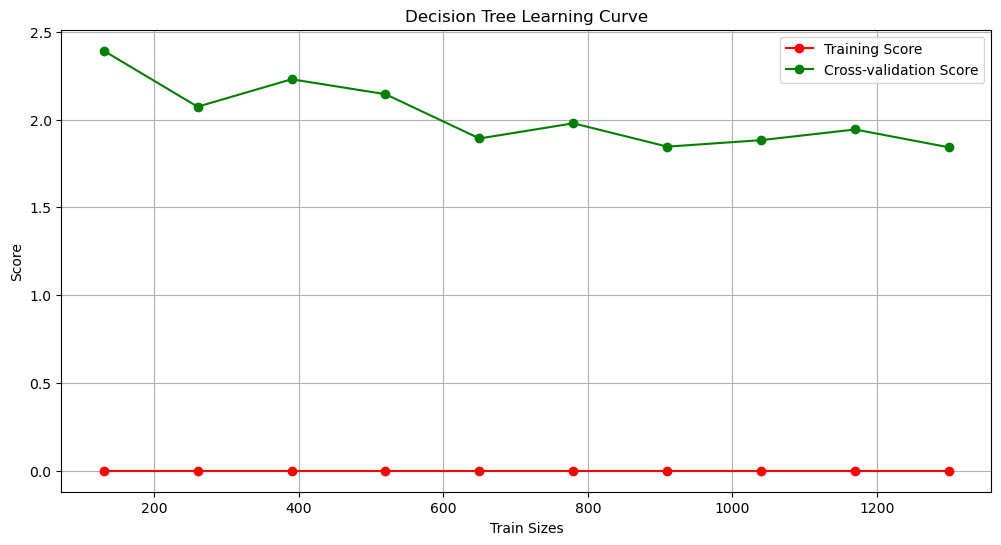

Decision Tree - Evaluation Metrics:
Mean Absolute Error (MAE): 0.845560943994721
Root Mean Squared Error (RMSE): 1.114195309510993
R-squared: 0.7353010003983281


In [187]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10]
}

# Initialize and fit GridSearchCV with verbose=3 for detailed output
dt_model = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_dt_model = grid_search.best_estimator_

plot_learning_curve(dt_model, X_train_scaled, y_train, title='Decision Tree Learning Curve')
print_evaluation_metrics(best_dt_model, X_test_scaled, y_test, title='Decision Tree')


## Methods Three: Support Vector Machine Regressor

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best parameters found:  {'C': 0.05, 'epsilon': 0.02, 'kernel': 'sigmoid'}


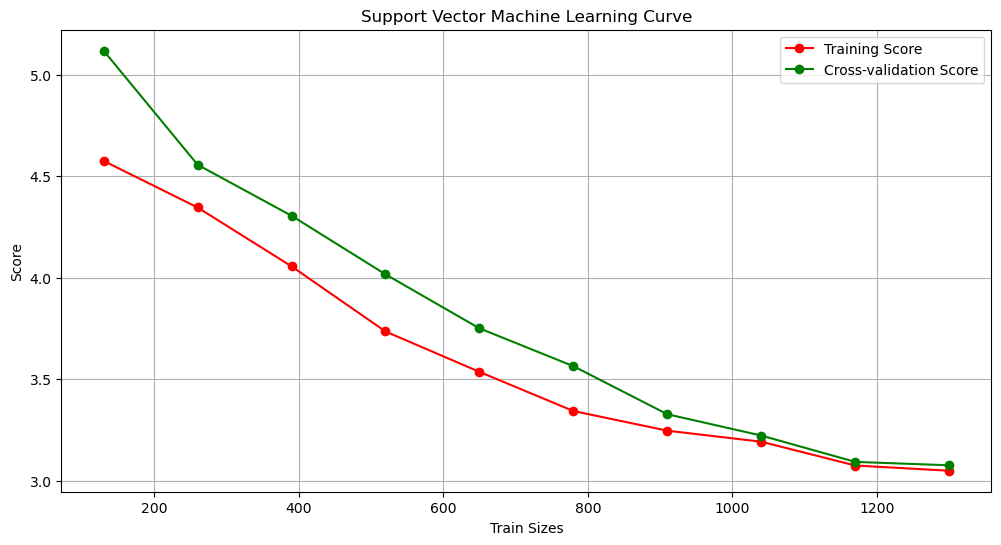

Support Vector Machine - Evaluation Metrics:
Mean Absolute Error (MAE): 1.424771084435031
Root Mean Squared Error (RMSE): 1.766725135936086
R-squared: 0.33447001946996047


In [188]:
param_grid = {
    'kernel': ['linear', 'poly', 'sigmoid'],
    'C': [0.05, 0.1, 0.5, 0.9, 1],
    'epsilon': [0.01, 0.015, 0.02, 0.05, 0.1]
}

# Initialize and fit GridSearchCV
svm_model = SVR()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error',  verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_svm_model = grid_search.best_estimator_

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

plot_learning_curve(best_svm_model, X_train_scaled, y_train, title='Support Vector Machine Learning Curve')
print_evaluation_metrics(best_svm_model, X_test_scaled, y_test, title='Support Vector Machine')

# Feature Analysis

Train the best-performing method from the previous section using the dimension-reduced data. 
**How did the model performance change? Provide your analysis.**